# Introduction
#### This graphical summary has the following sections
- Preprocessing
- Topic modeling
- Document clustering accross topic hierarchy
- Topic hierarchy visualization

## Preprocessing
### Steps
- Full texts were collected to local Zotero library using [Zotero connector](https://www.zotero.org/download/connectors)
- Text was extracted using [PyPDF2](https://pypdf2.readthedocs.io/en/3.0.0/)
- Punctuation was removed using [nltk](https://www.nltk.org/) and [regular expressions](https://docs.python.org/3/library/re.html).
- Texts were tokenized using [nltk](https://www.nltk.org/).
- Tokens that occurred in a document less than 3 or more than 950 times were removed as suggested in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.).
- Additionally tokens that consisted of the same two character combination by more than 50% of length were removed. 
    - It was discovered via manual inspection of pre-processed dataset that this step helps to reduce number of uninformative tokens<br>(also see Figure 1 and 2).
- Stop word removal was conducted using stop word list from [nltk](https://www.nltk.org/) that was extended to reduce the number of uninformative terms.
- Coocurrence counts were calculated for both datasets using custom python script with window size of 10 tokens.
- The corpus and coocurrence counts were saved in a format accepted by the [BigARTM library](https://docs.bigartm.org/en/latest/api_references/python_interface/dictionary.html?highlight=cooc#artm.Dictionary.gather) and used to construct hierarchical topic models.

In [1]:
# Imports & setups
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import artm
import plotly.graph_objects as go
import plotly.express as px
import random
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed
from wordcloud import WordCloud
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nlp_data_path = '../Data/metadata/nlp_tf_1.csv'
bit_data_path = '../Data/metadata/bit_tf_1.csv'

nlp_data = pd.read_csv(nlp_data_path).sort_values(by='max_dimer_freq', ascending=False)
bit_data = pd.read_csv(bit_data_path).sort_values(by='max_dimer_freq', ascending=False)

def df_tf_plot(data, title:str=None, threshold=0.5, ax=None):
    count_by_dim_freq = data.groupby('max_dimer_freq').agg({'term':'count'}).reset_index()
    if ax is None:
        ax = plt.gca()
    count_by_dim_freq.plot.bar(x='max_dimer_freq', y='term', legend=None,ax=ax)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_ylabel('term_count')

def plot_wordcloud(term_list:list, title:str=None, ax=None):
    long_string = ','.join(term_list)
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    
    # Adjust the plotting based on whether an ax is provided
    if ax is not None:
        # Use the provided axes object for plotting
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')  # Hide the axes
        if title is not None:
            ax.set_title(title)  # Set title if provided
    else:
        # No axes object provided, use plt to create and show the plot
        plt.figure(figsize=(6, 4))  # Optional: Adjust figure size
        plt.imshow(wordcloud, interpolation='bilinear')
        if title is not None:
            plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
           


def check_threshold(data,value=0.5):
    print(f'Testing with dimer frequency threshold = {value}.')
    noise = data[data['max_dimer_freq']>=value]
    df_tf_plot(noise, title='Noise term distribution by dimer frequency')
    plot_wordcloud(noise['term'], title='Noise wordcloud')
    clean = data[data['max_dimer_freq']<value]
    display(noise.tail(15))
    df_tf_plot(clean, title='Clean data term distribution by dimer frequency')
    plot_wordcloud(clean['term'], title='Clean data wordcloud')

def grid_plot(data, step=0.1):
    thresholds = np.arange(0, 1.1, step)
    nrows = len(thresholds)  # Determined by the number of thresholds
    ncols = 4  # Fixed number of columns: two for df_tf plots, two for word clouds
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))  # Adjusted figsize for better layout
    
    for i, threshold in enumerate(thresholds):
        noise = data[data['max_dimer_freq'] >= threshold]
        clean = data[data['max_dimer_freq'] < threshold]
        
        # Adjusting call to df_tf_plot and plot_wordcloud to use current axis
        if not noise.empty:
            df_tf_plot(noise, title=f'Noise >= {threshold:.1f}', threshold=threshold, ax=axs[i, 0])
            plot_wordcloud(noise['term'].tolist(), title='Noise Wordcloud', ax=axs[i, 2])
        else:
            axs[i, 0].text(0.5, 0.5, 'No noise data', ha='center', va='center', transform=axs[i, 0].transAxes)
            axs[i, 2].axis('off')
        
        if not clean.empty:
            df_tf_plot(clean, title=f'Clean < {threshold:.1f}', threshold=threshold, ax=axs[i, 1])
            plot_wordcloud(clean['term'].tolist(), title='Clean Wordcloud', ax=axs[i, 3])
        else:
            axs[i, 1].text(0.5, 0.5, 'No clean data', ha='center', va='center', transform=axs[i, 1].transAxes)
            axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

## Comments on grid plot structure
- The grid plots shows number of tokens by the maximum observed fraction <br>of token length that consisted of the same two character combination. 
- Each row shows result of a dataset split, given fraction of length threshold.
- The first column shows the count distribution for tokens above threshold (termed Noise here).
- The second column shows the count distribution for tokens below threshold (termed Clean here).
- The third column shows the wordcloud plot for the "Noise" tokens.
- The fourth column shows the wordcloud plot for the "Clean" tokens.

## Figure 1: Repeated dimer filtering - natural language processing dataset

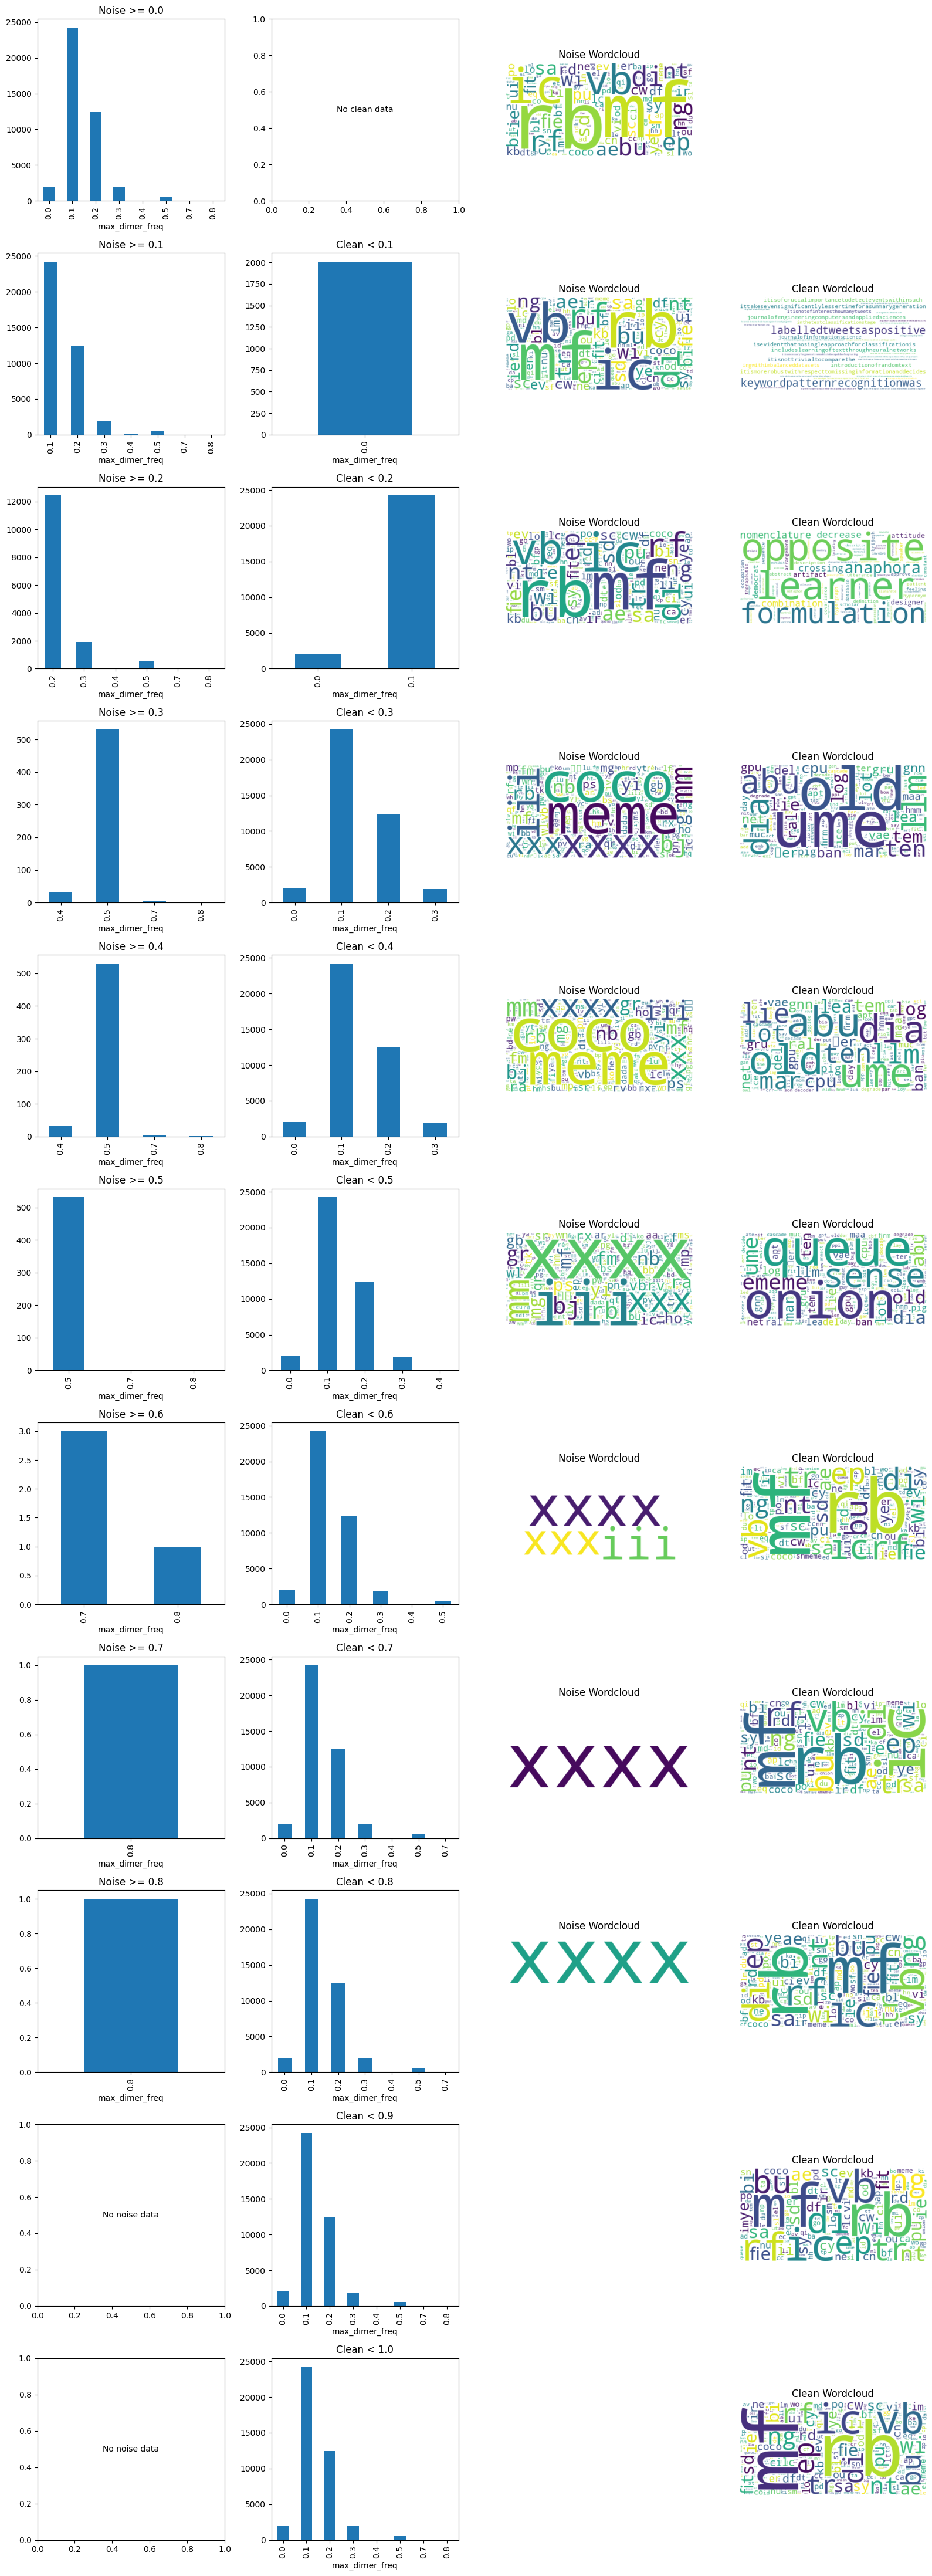

In [3]:
grid_plot(nlp_data)

## Figure 2: Repeated dimer filtering - bioinformatics dataset

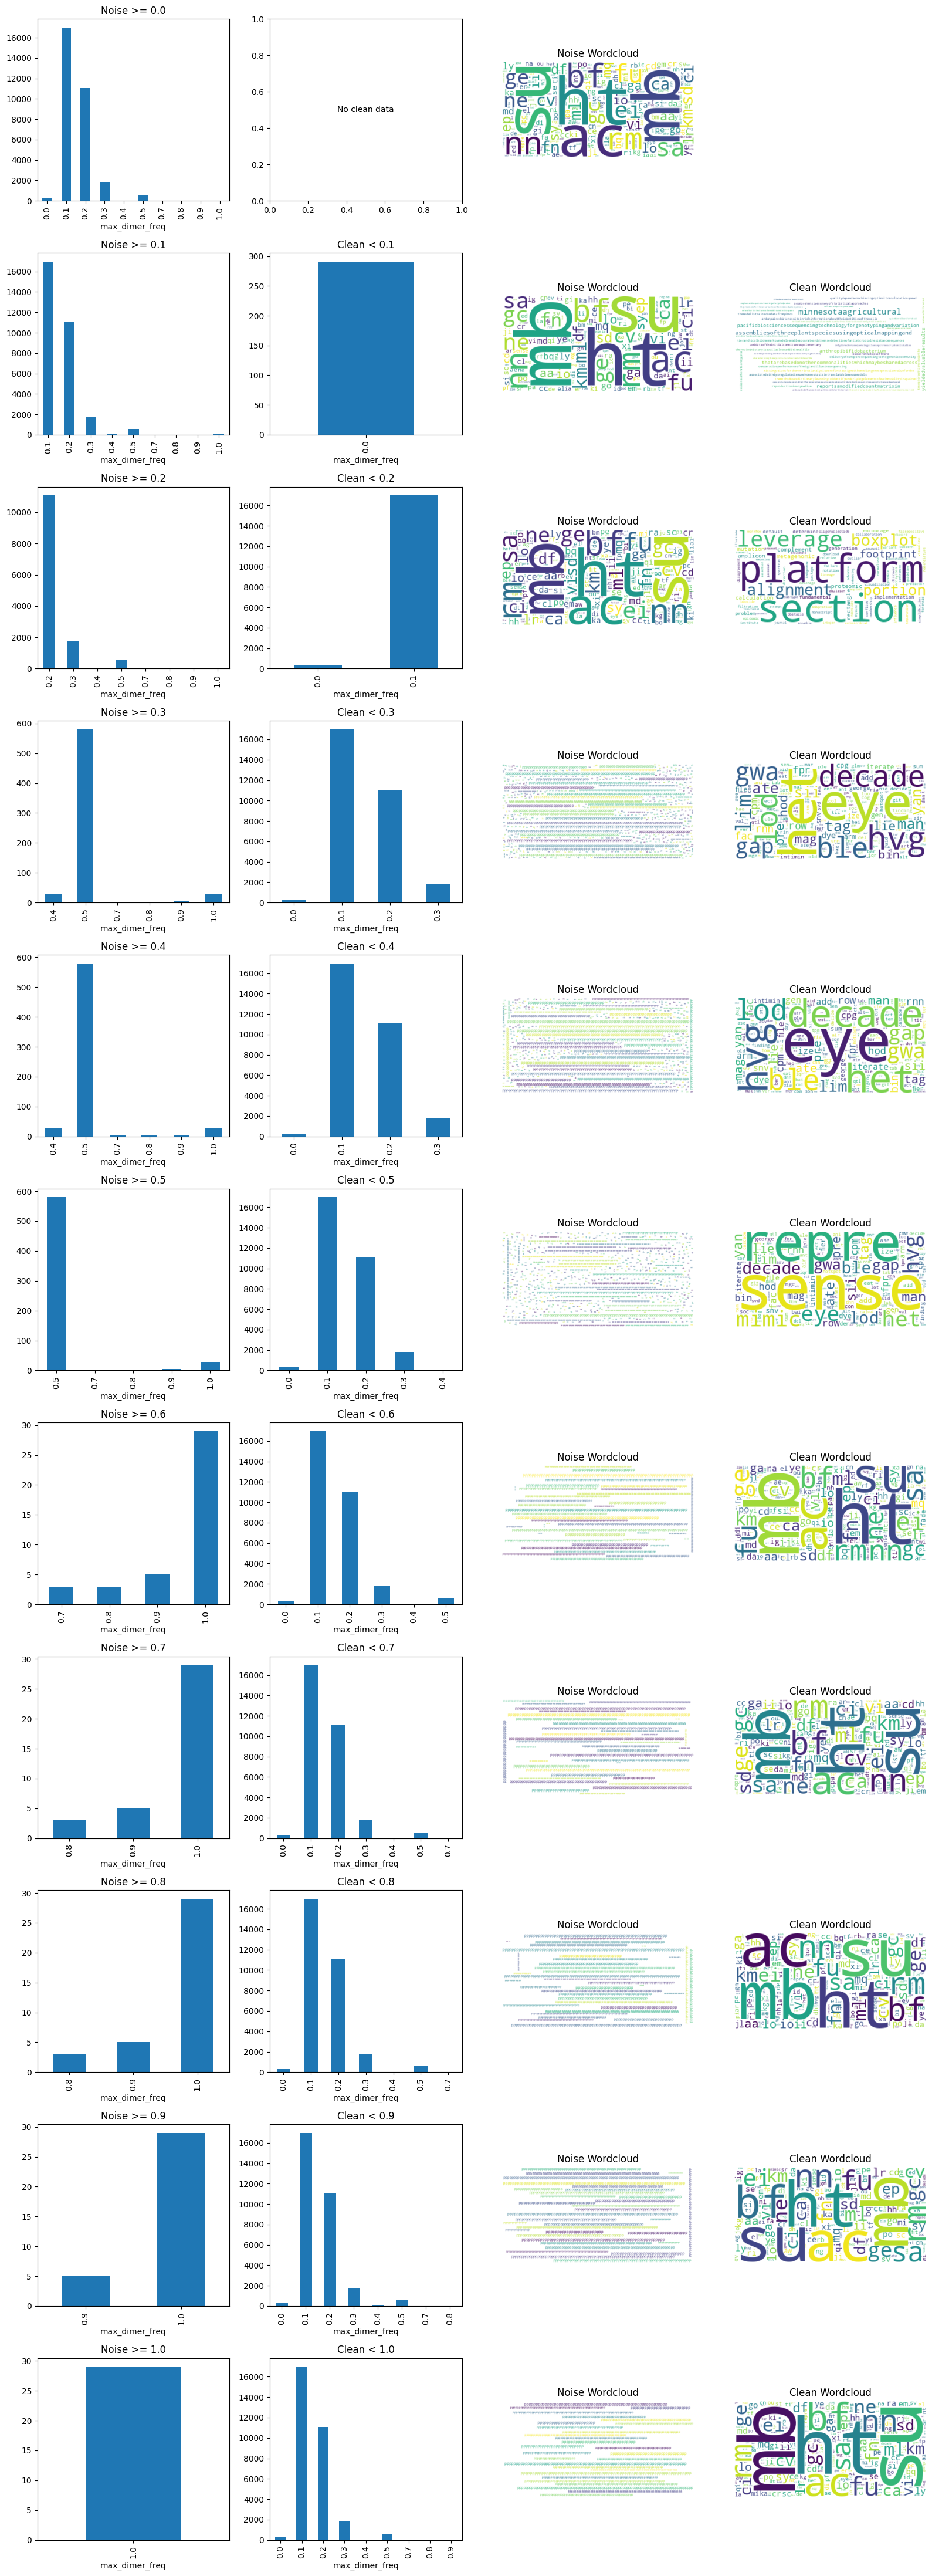

In [4]:
grid_plot(bit_data)

## Topic modeling
- BigARTM-based implementation of the approach described in [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) was used.
- As a moment of novelty - the model architecture discussed in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.) for single-level topic model was implemented here for the hierarchical case with some adjustements.
- Finally the calculation of Renyi entropy was implemented based on [Koltsov, S. et al. (2021)](https://doi.org/10.7717/peerj-cs.608) in order to attempt optimizing the number of topics along with other parameters of the model using the approaches discussed in [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.) (optimization not implemented yet).
- The quality metric function was adopted from [BigARTM documentation](https://docs.bigartm.org/en/latest/tutorials/python_tutorial.html) to track the different aspects of model quality for each level of hierarchy accross training iterations as suggested in [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) and [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.). The results can be seen in figures 3 and 6.

## Document clustering accross the topic hierarchy
- Hierarchical topic model based on [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) allows to calculate a topic distribution for each document in the corpus.
- Such vectors represent discrete probability distributions and can be used to represent the documents at a given level of topic hierarchy in a way similar to the neural network embeddings.
- Additionally for each level of a topic hierarchy (except the first one) it is possible to get vectors representing super-topics in terms of sub-topics. This allows to treat super-topics (at the higher level of hierarchy) as pseudo-documents and include them into document matrix. This is the base of the approach for computing topic hierarchy asdescribed by [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05) and implemented in [BigARTM](https://docs.bigartm.org/en/latest/api_references/python_interface/hARTM.html).
- Calculating [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance) between the described vector (documents and pseudo-documents) was suggested as one of the quality metrics for the model in the original publication.
- In current woork it was attempted to extend this approach by implementing document similarity calculation using three additional steps:  
    - First, given a matrix of topic-based document distributions (termed Phi), and a matrix of pseudo-document distributions (termed Psi) a combined matrix (termed Phi_Psi) is generated. 
    - Next the square pairwise distance matrix is calculated from Psi_Phi using Hellinger distance formula. 
    - Finally the distance matrix is converted into a similarity matrix using Bhattacharyya coefficient as discussed in [Kitsos, C.P. and Nisiotis, C.-S. (2022)](https://doi.org/10.2478/bile-2022-0006).
    - Using the resulting similarity matrix it was possible to perform spectral clustering of documents to assign groups of topic-based similarity within each level of topic hierarchy using [scikit-learn package](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html). 
    - It was also possible to visually represent documents at each level of hierarchy in two-dimensional space using [Multidimensional scaling](https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#multidimensional-scaling) with the distance matrix calculated from Phi_Psi to generate a scatter plot.
    - This plot was additionally annotated with document indices and connections between documents were shown where pairwise Hellinger distance values between the documents were below the specified threshold. The resulting plots are shown in figures 4 and 7.
    - Tables illustrate inf figures 4 and 7 show correspondance between maximum probability topic index and cluster assigned by the described approach.
        - Sankey plots allow to see the discrepancies between spectral clustering results and topic labels with highest probabilities at a given layer.
    - Additional Sankey plot allows to visualize the correspondence between cluster ids assigned at different levels of topic hierarchy, indicating the degree of connectivity between clusters at those levels.
    
## Topic hierarchy visualization
- An additional function was developed to represent all levels of topic hierarchy and include any connections between the layers with model-assigned probability value above a specified threshold. This allows to show the resulting topic hierarchy and the connections discovered by the model.
- The resulting plots are shown in figures 5 and 8.

### Main conclusions
- Hierarchical topic modeling based on BigARTM library allows to construct an interpretable topic hierarchy using topic coherence as target metric - confirmed results from [Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.) and [Chirkova, N.A., 2016](https://doi.org/10.21469/22233792.2.2.05).
- Additive regularization approach allows to control the parameters of the model, including:
    - **Topic sparsity** - resulting in set of topics represented by a limited set of application-area-specific tokens.
    - **Topic distinctiveness** - resulting in uncorrelated token distributions between topics.
    - **Sparcity of connections between hierarchy levels** - allowing to adjust the degree to which the model expects the supertopic to cover small set of sub-topics vs broad sub-topic range.
    
- For the data at hand it can be concluded that the results of proposed spectral clustering approach in most cases discover groups that correspond to the most probable topic assigned by topic model at a given level of the hierarchy (see Sankey plots for clustering results and top-P topic id in figures 4. and 7.). 
- This is an expected result, since topic modeling can be viewed as a form of soft clustering. However the correspondence was demonstrated not to be 100%, which is most likely related to the cases when topic model assigns close values of probability to multiple topics for the same document. 
- The resulting spectral clustering approach is expected to allow converting the soft clustering output of the topic model into hard clustering results more accurately than it could be achived by taking only the most probable topic assigned by the model directly, since the similarity used for spectral clustering was calculated using the entire vector of topic probabilities instead of taking maximum value.
- The resulting conversion allows to construct Sankey diagram to show the connectivity between document clusters at different levels of topic hierarchy. This allows to visualize the the structure of the hierarchy allong with degree of connectivity between clusters at different levels of topic hierarchy.

### Future directions
- It would be interensting to try optimizing the parameters of the model, specifically:
    - Regularization coefficients.
    - Number of training iterations at each training session.
    - Number of topics at each level of hierarchy.
- The approach for optimizing regularization coefficients and training iterations could be implemented 
by maximizing coherence-based target function (perhaps in combination with other quality metrics), as suggested in 
[Khodorchenko, M. et al. (2020)](https://doi.org/10.1007/978-3-030-61705-9_24.)
- The approach for optimizing number of topics at each level of hierarchy could be based on minimizing Renyi entropy as target function as suggested in [Kitsos, C.P. and Nisiotis, C.-S. (2022)](https://doi.org/10.2478/bile-2022-0006)

In [5]:
# To be used as target function to optimize model's parameters
def get_renyi_entropy(model, dictionary, num_topics):
    '''
    Function to calculate Renyi entropy 
    for hierarchical topic model 
    based on https://doi.org/10.7717/peerj-cs.608
    '''
    
    #Getting token probability distribution for each topic
    phi = model.get_phi()
    phi_np = phi.to_numpy()
    
    #Getting number of words in the dictionary
    W = int(str(dictionary).split(" ")[-1][:-1].split("=")[-1])
    
    #Calculating uniform distribution threshold value
    p_uniform = 1/W
    
    #Filtering the phi_wt matrix based on threshold
    phi_gt_uniform = phi_np[phi_np > p_uniform]
    
    #Getting number of entries above threshold
    N = len(phi_gt_uniform)
    
    #Getting number of topics in the model
    T = num_topics
    
    #Calculating Gibbs-Shannon entropy
    S = np.log(N/(W*T))
    
    #Calculating internal energy
    E = -np.log((1/T)*np.sum(phi_gt_uniform))
    
    #Calculating deformation parameter
    q = 1/T
    
    #Calculating Renyi entropy value
    S_qR = (-q*E+S)/(q-1)
    return S_qR

In [6]:
def train_hier_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    regularizers:list,
    num_levels:int,
    topics_per_level:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
) -> (artm.ARTM, list):
    '''
    Wrapper to train hierarchical unimodal topic model
    using the algorithm suggested by https://doi.org/10.1007/978-3-030-61705-9_24
    '''
   
    
    # Defining the hierarchical model object as container for models to represent levels
    model_artm = artm.hARTM(
        regularizers = regularizers,
        scores=scores,
        cache_theta=True
    )
    
    
    #Adding levels to the model
    level_dict = {} # to access each level model by its id
    for i in range(num_levels):
        level_id = f'level_{i}'
        level_dict[level_id] = model_artm.add_level(
            num_topics=int(topics_per_level[i]),
            parent_level_weight = 0.5
        )

        #Initialize - as required by the documentation
        #https://docs.bigartm.org/en/latest/api_references/python_interface/hARTM.html#artm.hARTM.add_level
        level_dict[level_id].initialize(dictionary = cooc_dict)
        level_dict[level_id].fit_offline(
            batch_vectorizer      = batch_vectorizer, 
            num_collection_passes = 1)
        
    #Setting regularization coefficient for the 1st training session
    #Note - all levels share the same regularizers and regularization parameters
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #Performing first training session of n1 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Setting regularization coefficient for the 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Performing second training session of n2 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Setting regularization coefficient for the 3rd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Performing third training session of n3 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Setting regularization coefficient for the 4th training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Performing fourth training session of n4 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n4)
    
    '''
    The steps below allow to expose parameters of the model and
    perform target function calculation which will be required to
    optimize parameters of the model.
    '''
    
    #Calculating Renyi entropy for each level and on-average
    S_qR_dict = {}
    mean_S_qR = 0
    # Calculation for level 1 is not relevant
    for i in range(1,num_levels):
        level_id = f'level_{i}'
        level = level_dict[level_id]
        S_qR = get_renyi_entropy(
            model=level, 
            dictionary=dictionary,
            num_topics=topics_per_level[i]
        )
        S_qR_dict[f'{level_id}'] = S_qR
        #Average Renyi entropy accross levels to use in score calculation
        mean_S_qR += S_qR/num_levels
    
    #Exposing regularization coefficients
    parameters = {
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ],
        'TopicsPerLevel': topics_per_level
    }
    
    #Generating parameter list
    flat_params = sum(list(parameters.values()),[])    
    
    #Calculating target function for the model with given parameters
    #Target function defined based on https://doi.org/10.1007/978-3-030-61705-9_24
    #In terms of topic coherence score calculated using the core (p>0.3) for each topic
    min_fc_list = []
    mean_fc_list = []
    for i in range(num_levels):
        min_fc_list.append(min(model_artm.get_level(i)._score_tracker['TopKernelScore Coherence'].coherence[-1].values()))
        mean_fc_list.append(model_artm.get_level(0)._score_tracker['TopKernelScore Coherence'].average_coherence[-1])
    min_fcoherence = np.array(min_fc_list)
    mean_fcoherence = np.array(mean_fc_list)
    # Minimizing Entropy to select optimal number of topics at each level
    # Maximizing coherence to improve topic interpretability
    fitness = np.sum(min_fcoherence + mean_fcoherence) - mean_S_qR
    return model_artm, flat_params, fitness, parameters, mean_S_qR

In [7]:
def print_measures(model:list):
    '''
    Function to summarize final score values of single level.
    Additionally plots quality metric values accross training iterations for single level.
    '''
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

In [8]:
def print_tpc_top_tkns(model, num_levels):
    '''
    Print top tokens for each topic at every level of hierarchical ARTM model.
    '''
    for i in range(num_levels):
        print(f'\nlevel{i}\n')
        for topic_name in model.get_level(i).topic_names:
            print(
                topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

In [9]:
def hellinger_distance(p, q):
    '''
    Function to calculate Hellinger distance 
    between two discrete probability distribution vectors.
    Based on https://doi.org/10.21469/22233792.2.2.05.
    '''
    #Ensure the vectors are numpy arrays and normalized to sum to 1
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    #Calculate the Hellinger distance
    distance = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    return distance

In [10]:
def get_distance_matrix(model, level_id):
    '''Calculates pairwise Hellinger distances from combined theta and psi matrices'''
    
    if level_id == 0:
        #Psi is only available if current level has parent level associated with it
        theta_psi = model.get_level(level_id).get_theta()
    else:
        #getting document embeddings for a given level
        theta = model.get_level(level_id).get_theta()

        #getting topic embeddings in terms of parent level 
        psi = model.get_level(level_id).get_psi()
        #Including embeddings for parent topics with documents
        theta_psi = theta.join(psi)

    #Distance matrix between documents using hellinger distance
    hlg_matrix = np.zeros((len(theta_psi.columns), len(theta_psi.columns)))
    for i, col1 in enumerate(theta_psi.columns):
        for j, col2 in enumerate(theta_psi.columns):
            hlg_matrix[i, j] = hellinger_distance(theta_psi[col1].values, theta_psi[col2].values)
    hlg_df = pd.DataFrame(hlg_matrix, columns=theta_psi.columns, index=theta_psi.columns)
    return hlg_df

In [11]:
def get_spectral_clusters(distance_matrix, num_topics):
    '''
    Perform spectral clustering based on pairwise distance matrix 
    and number of topics for a given level of the model.
    Bhattacharyya coefficient is a similarity measure related to Helligner distance,
    based on https://doi.org/10.2478/bile-2022-0006:
        HD = (1 − BC)^1/2
        BC = 1 - HD^2 
    '''
    # Convert the distance matrix to a similarity matrix
    similarity_matrix = 1 - distance_matrix.to_numpy()**2

    # Apply spectral clustering
    clustering = SpectralClustering(n_clusters = num_topics, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)

    # 'labels' now contains the cluster assignments for each point
    return labels

In [12]:
def plot_clustering_results(dm, labels, threshold, level_id, n_components=2):
    '''
    Using Multidimensional Scaling to project distance matrix into 2D or 3D space 
    and visualize connections based on Hellinger distance threshold for a given level of the model.
    Based on https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/
    '''
    # Initialize MDS with the specified number of components (2D or 3D)
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42) #to fix document positions on rerun
    
    #Get document names from distance matrix to annotate the points
    doc_names = dm.columns
    
    #Transform dm into required number of dimensions for visualization using MDS
    data_transformed = mds.fit_transform(dm.to_numpy())

    # Create a plot based on the number of components
    fig = plt.figure()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_func = ax.scatter
    else:
        ax = fig.add_subplot(111)
        plot_func = ax.scatter

    # Configure color map
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster
    for label, color in zip(unique_labels, colors):
        idx = np.where(labels == label)[0]  # Indices of points in the current cluster
        if n_components == 3:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                data_transformed[idx, 2], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )
        else:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )

        # Annotate each point in the cluster
        for point in idx:
            text = doc_names[point] if 'topic' not in str(doc_names[point]) else f'{doc_names[point]}_{level_id-1}'
            if n_components == 3:
                ax.text(
                    data_transformed[point, 0], 
                    data_transformed[point, 1], 
                    data_transformed[point, 2], 
                    text, 
                    fontsize=9
                )
            else:
                plt.annotate(
                    text, 
                    (data_transformed[point, 0], data_transformed[point, 1]), 
                    textcoords="offset points",
                    xytext=(5,2),
                    ha='center',
                    fontsize=9
                )

    # Draw connections for distances below the threshold
    for i in range(len(data_transformed)):
        for j in range(i + 1, len(data_transformed)):
            if dm.iloc[i, j] < threshold:
                if n_components == 3:
                    ax.plot([data_transformed[i, 0], data_transformed[j, 0]],
                            [data_transformed[i, 1], data_transformed[j, 1]],
                            [data_transformed[i, 2], data_transformed[j, 2]], 'k-', alpha=0.1)
                else:
                    plt.plot([data_transformed[i, 0], data_transformed[j, 0]],
                             [data_transformed[i, 1], data_transformed[j, 1]], 'k-', alpha=0.1)

    plt.title(f'Spectral Clustering Results with MDS, level {level_id}')
    if n_components == 2:
        plt.xlabel('MDS1')
        plt.ylabel('MDS2')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.75) if n_components == 2 else None
    plt.show()

In [13]:
def plot_hierarchical_connections(model, num_levels, threshold=0.15, spacing = 25, image_width=15):
    '''
    Function to plot connections between topics in different layers
    of the hierarchical topic model based on probability threshold.
    '''
    
    # Extracting topic embedding matrices from the model
    matrix_list = []
    for level_id in range(1,num_levels):
        
        df = model.get_level(level_id).get_psi()
        df.columns = [f'{c}_{level_id-1}' for c in df.columns]
        df.index = [f'{c}_{level_id}' for c in df.index]
        matrix_list.append(df)

    G = nx.Graph()
    pos = {}
    layer_y = 0  # Y position for the first layer
    y_offset = -5  # Vertical offset for subsequent layers
    
    # Determine the total number of layers for positioning
    total_layers = len(matrix_list) + 1  # +1 to include the 0th layer explicitly

    # Image width for centering
    half_width = image_width / 2

    # Process the first dataframe separately
    first_df = matrix_list[0]
    columns = first_df.columns
    indices = first_df.index

    # Position columns of the first dataframe
    for i, col in enumerate(columns):        
        # Calculate positions
        current_x_positions = half_width - (len(columns) / 2 - i) * spacing
        pos[col] = (current_x_positions, layer_y)
        
    #Adding spacing between the first and 2nd layer
    layer_y += y_offset
    
    # Position indices of the first dataframe as the second layer
    for i, index in enumerate(indices):
        current_x_positions = half_width - (len(indices) / 2 - i) * spacing
        pos[index] = (current_x_positions, layer_y)
    

    # Add edges for the first dataframe based on Hellinger distance threshold
    for col in columns:
        for index in indices:
            if first_df.at[index, col] > threshold:
                G.add_edge(col, index)
                
    # Setting index of the first df as columns of the 2nd df
    columns = first_df.index
                
    # For subsequent dataframes, treat indices as the new layer connected to the previous layer's indices
    for i, df in enumerate(matrix_list[1:]):
        
        new_layer_y = layer_y + y_offset
        new_indices = df.index
        
        
        # Position new indices
        for i, index in enumerate(new_indices):
            new_x_positions = half_width - (len(new_indices) / 2 - i) * spacing
            pos[index] = (new_x_positions, new_layer_y)
        
        # Add edges based on threshold, connecting previous indices to new indices
        for col in columns:  # Previous layer's indices now act as "columns"
            if col not in df.columns:
                continue  # Skip this parent topic if it has no child subtopics in this level
            for index in new_indices:
                    if df.at[index, col] > threshold:
                        G.add_edge(col, index)
        
        # Update for the next iteration
        layer_y = new_layer_y
        columns = new_indices  # The current indices become "columns" for the next layer

    # Draw the graph
    plt.figure(figsize=(image_width, 3 * total_layers))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, edge_color='k')
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()

In [14]:
def get_clustering_maxp_topic(model, labels, doc_names):
    '''
    Showing top-1 probability topic index vs cluster number for every document in table form.
    '''
    theta = model.get_theta().reset_index(drop=True)
    clusters = doc_names.join(pd.DataFrame(labels, columns=['cluster_id']))
    clusters = clusters.join(pd.DataFrame(theta.idxmax(), columns=['max_p_topic_id']))
    return clusters

In [15]:
def plot_sankey(df, title):
    # Create mappings for source and target
    source_target_df = df.groupby(['cluster_id', 'max_p_topic_id']).size().reset_index(name='count')

    # Map unique IDs for source and target
    cluster_ids = pd.Categorical(source_target_df['cluster_id'])
    max_p_topic_ids = pd.Categorical(source_target_df['max_p_topic_id'], categories=source_target_df['max_p_topic_id'].unique())

    source = cluster_ids.codes
    target = max_p_topic_ids.codes + cluster_ids.codes.max() + 1

    # Create figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=list(cluster_ids.categories) + list(max_p_topic_ids.categories)
        ),
        link=dict(
            source=source,
            target=target,
            value=source_target_df['count']
        ))])

    fig.update_layout(title_text=title, font_size=10)
    fig.show()

In [16]:
def plot_full_sankey(df, title='Sankey Diagram for Articles and Clusters'):
    # Extract cluster_id columns and doc_names
    cluster_columns = [col for col in df.columns if 'cluster_id' in col]
    
    # Initialize lists for sources, targets, labels, and customdata for hover info
    sources = []
    targets = []
    labels = []
    customdata = []  # Custom data for each link, including doc_name and source/target labels for hover
    label_to_id = {}  # Maps cluster labels to unique IDs
    current_id = 0
    
    # Process each row in the DataFrame
    for index, row in df.iterrows():
        for i in range(len(cluster_columns) - 1):
            source_label = f"{cluster_columns[i]}_{row[cluster_columns[i]]}"
            target_label = f"{cluster_columns[i+1]}_{row[cluster_columns[i+1]]}"
            
            # Assign unique IDs to new labels and add them to the labels list
            if source_label not in label_to_id:
                label_to_id[source_label] = current_id
                labels.append(source_label)
                current_id += 1
                
            if target_label not in label_to_id:
                label_to_id[target_label] = current_id
                labels.append(target_label)
                current_id += 1
            
            # Append source, target, and doc_name to the respective lists
            source_id = label_to_id[source_label]
            target_id = label_to_id[target_label]
            sources.append(source_id)
            targets.append(target_id)
            # For customdata, include both the document name and the source/target labels
            customdata.append([row['doc_names'], labels[source_id], labels[target_id]])
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=["-".join(label.split('_')[-2:]) for label in labels],  # Display cleaner label text
        ),
        link=dict(
            source=sources,
            target=targets,
            value=[1]*len(sources),  # Set all connection values to 1
            customdata=customdata,
            # Use hovertemplate to show document name, source, and destination
            hovertemplate='Document: %{customdata[0]}<br>Source: %{customdata[1]}<br>Destination: %{customdata[2]}<extra></extra>',
        ))])
    
    fig.update_layout(title_text=title, font_size=10)
    fig.show()

# Results for BIOIT set

In [62]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [63]:
#Preparing list of document names
with open(f'{input_folder}bioit_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

In [64]:
#Number of topics
num_levels = 5
topics_per_level = [4, 6, 8,10, 12] #should be increasing with index

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [65]:
%%time
#Training the model
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict,
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 49.8 s, sys: 15.7 s, total: 1min 5s
Wall time: 21.4 s


In [66]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(model, num_levels)


level0

topic_0:  ['gene_expression', 'differential_expression', 'nanopore_sequencing', 'cell_types', 'single_cell', 'oup_guest', 'per_cent', 'control_genes', 'genome_biol', 'ngs_technology']
topic_1:  ['short_reads', 'ion_torrent', 'sequencing_data', 'data_set', 'data_sets', 'wgs_data', 'nucleic_acids', 'metagenomic_data', 'long_reads', 'additional_file']
topic_2:  ['reference_genome', 'read_alignment', 'nat_biotechnol', 'nat_methods', 'author_manuscript', 'dna_hashing', 'read_length', 'annu_rev', 'alignment_algorithms', 'downloaded_annualreviews']
topic_3:  ['lung_cancer', 'liquid_biopsy', 'deep_learning', 'circulating_tumor', 'sequencing_data', 'functional_genomics', 'tumor_dna', 'machine_learning', 'accessed_march', 'spring_harbor']

level1

topic_0:  ['fuzzy_simplicial', 'data_points', 'nanopore_sequencing', 'simplicial_set', 'simplicial_sets', 'antimicrobial_resistance', 'dimension_reduction', 'microbial_genomics', 'bipolar_cells', 'additional_file']
topic_1:  ['gene_expression'

### Figure 3. Quality metrics accross training iterations for hierarchical model - bioinformatics dataset


Results for level 0

Sparsity Phi: 0.714 
Sparsity Theta: 0.056
Kernel contrast: 0.934
Kernel purity: 0.947


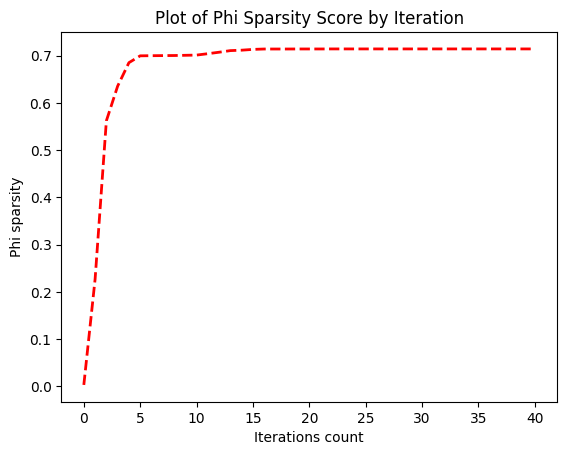

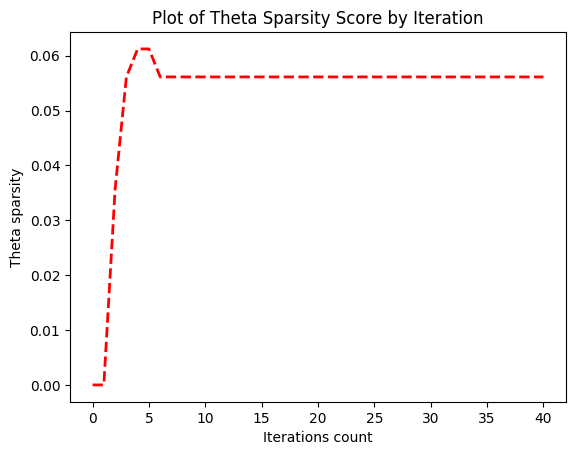

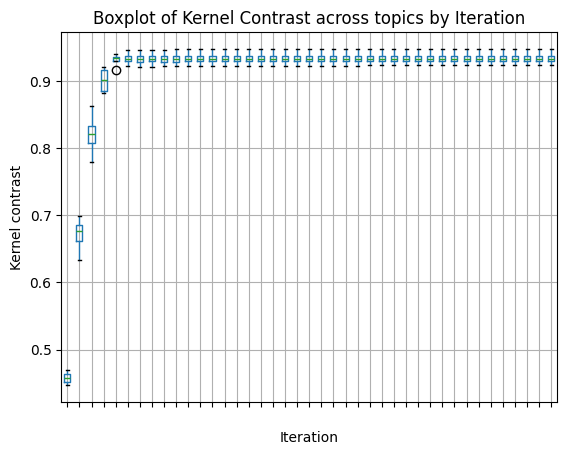

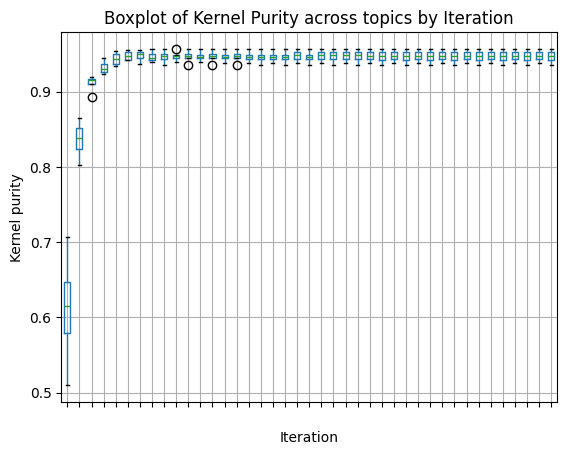

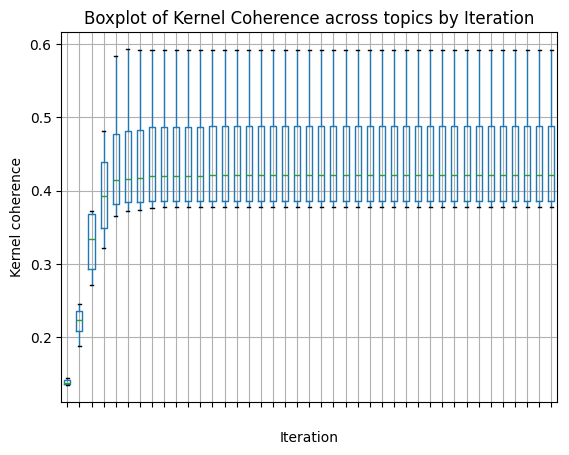


Results for level 1

Sparsity Phi: 0.808 
Sparsity Theta: 0.167
Kernel contrast: 0.929
Kernel purity: 0.945


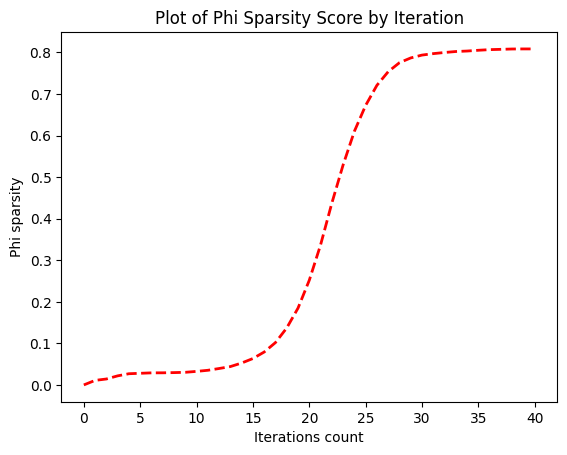

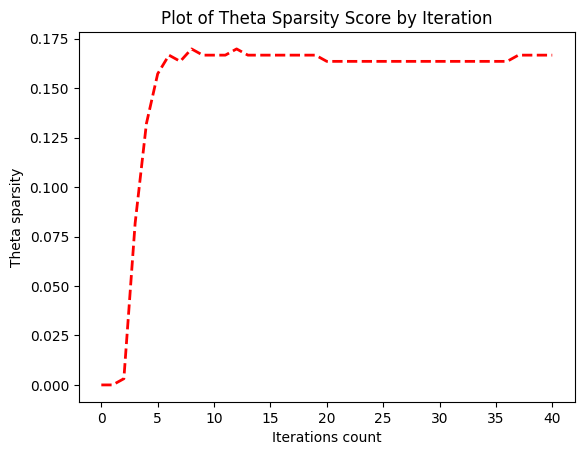

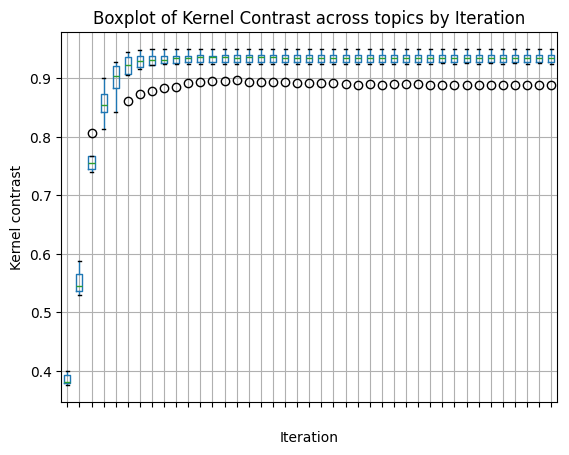

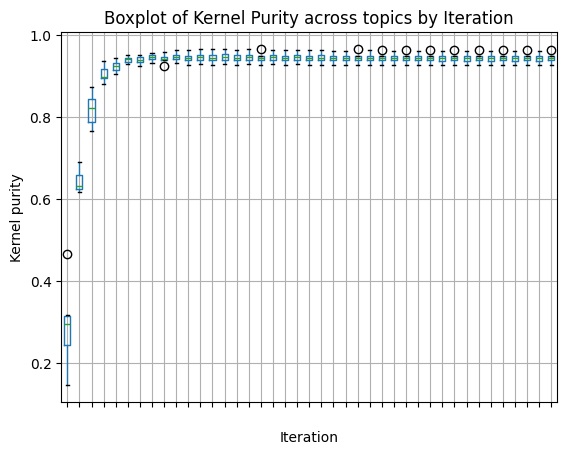

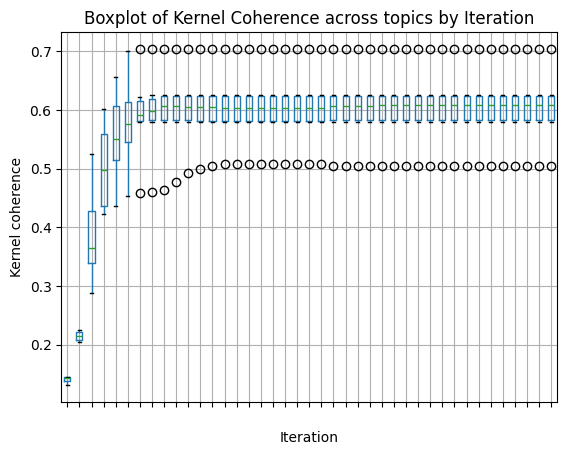


Results for level 2

Sparsity Phi: 0.853 
Sparsity Theta: 0.277
Kernel contrast: 0.941
Kernel purity: 0.965


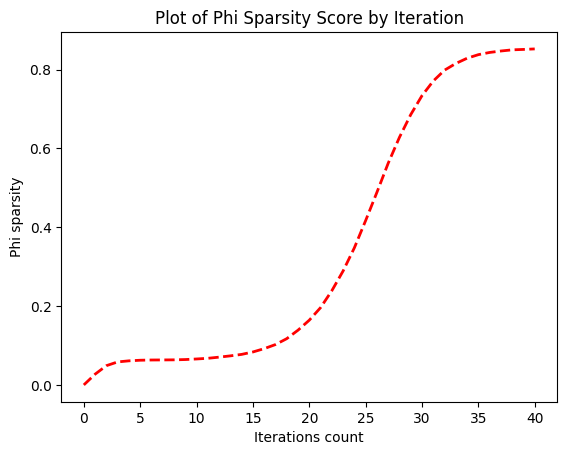

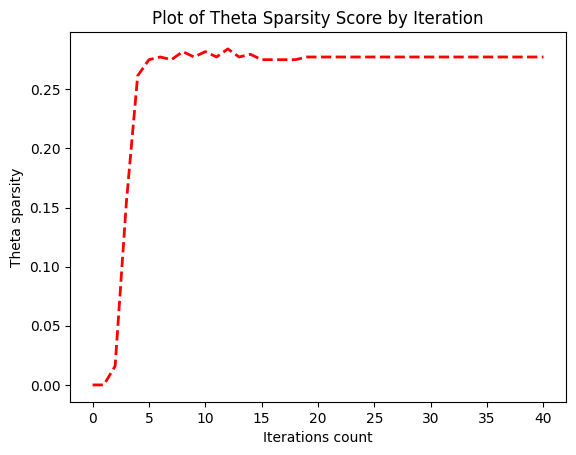

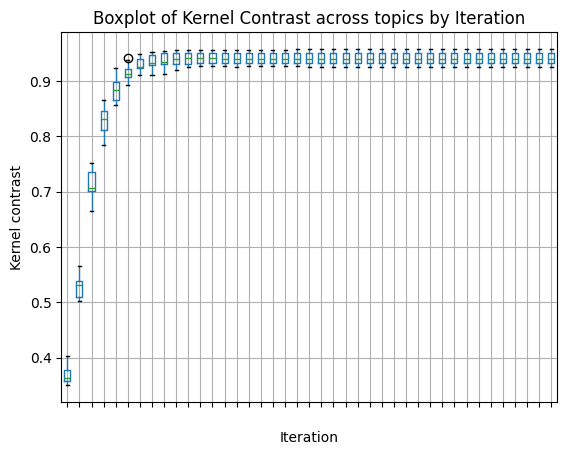

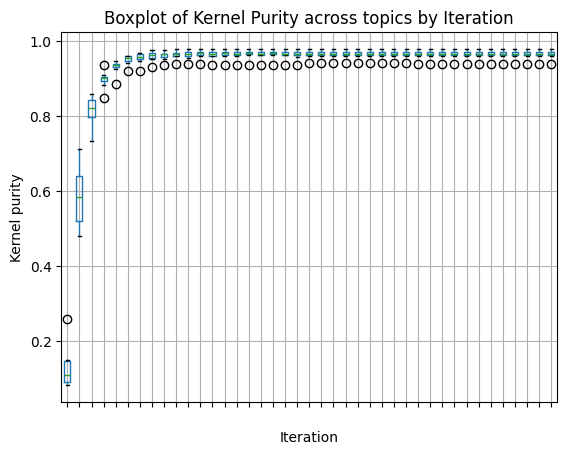

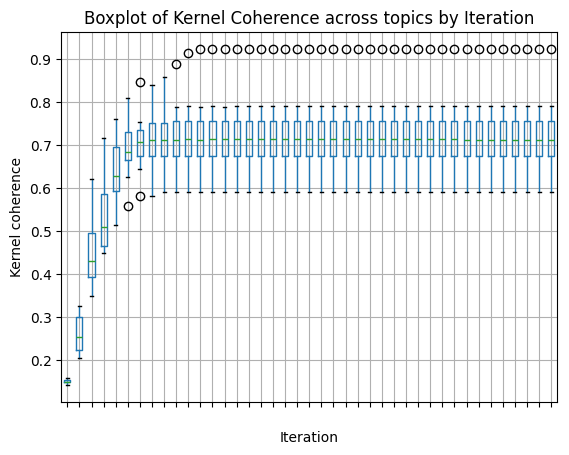


Results for level 3

Sparsity Phi: 0.884 
Sparsity Theta: 0.395
Kernel contrast: 0.945
Kernel purity: 0.970


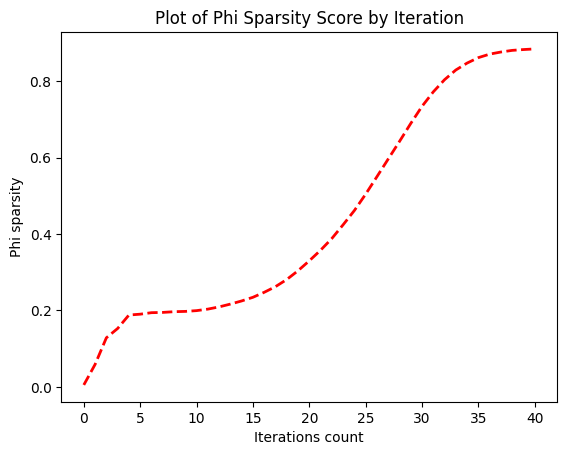

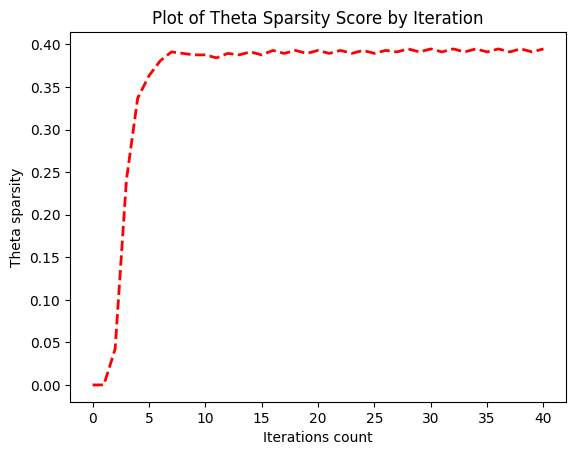

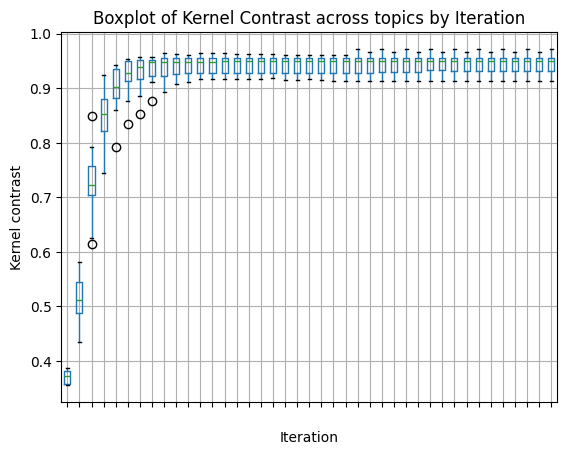

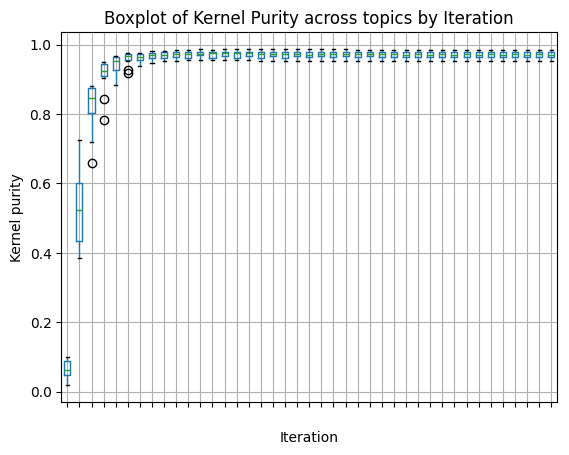

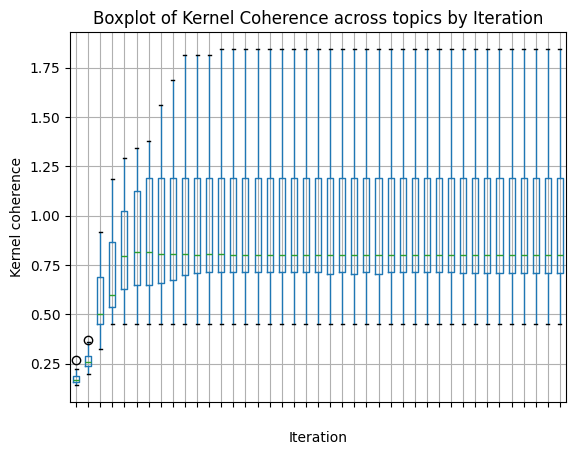


Results for level 4

Sparsity Phi: 0.000 
Sparsity Theta: 0.000
Kernel contrast: 0.509
Kernel purity: 0.518


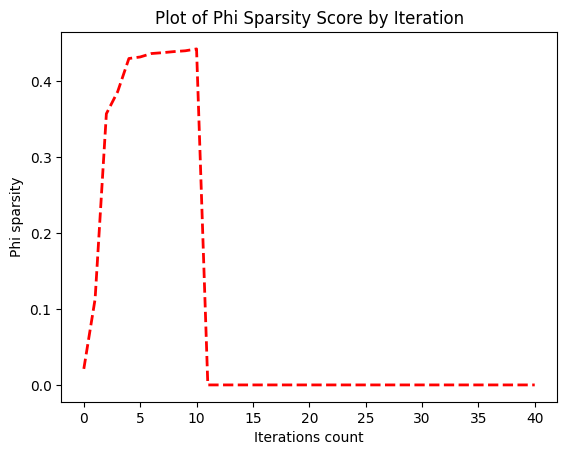

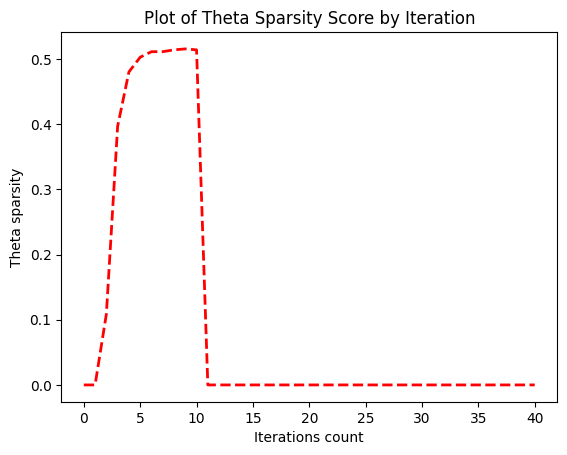

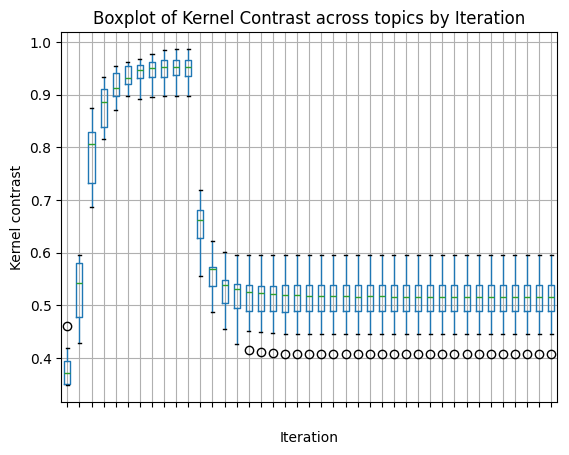

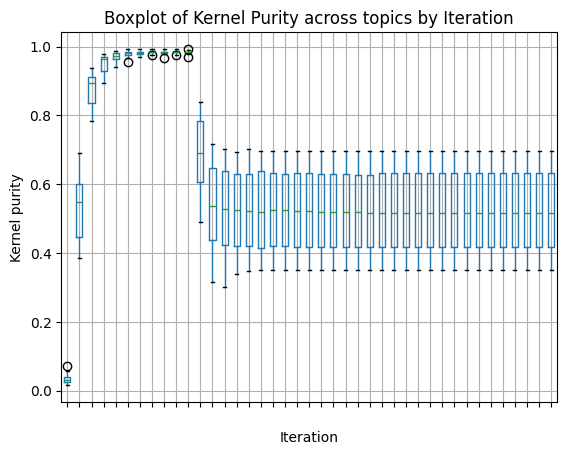

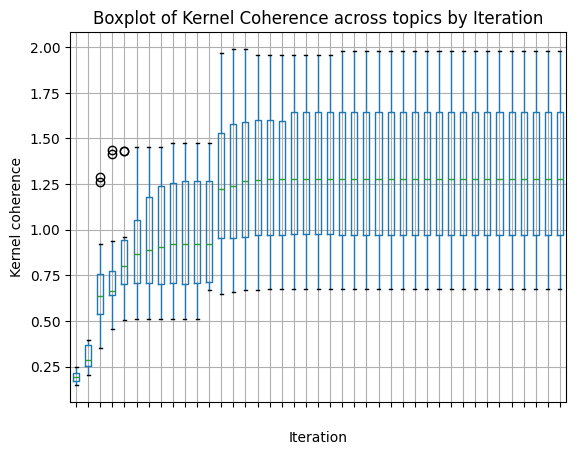

In [67]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(model.get_level(level_id))

### Figure 4. Spectral clustering results - bioinformatics dataset

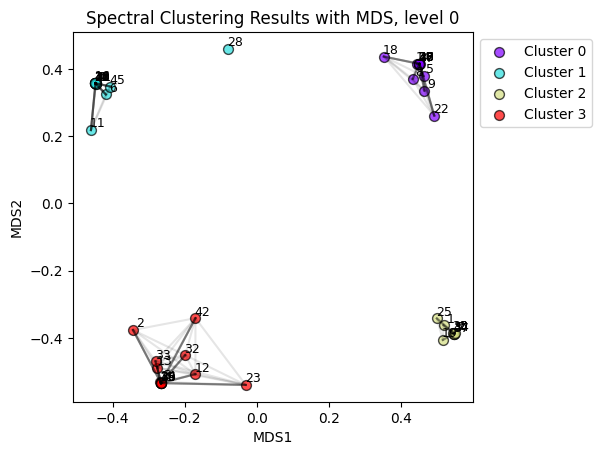

doc_names  \
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
8                   Bonin_et_al._-_2023_-_MEGARes_and_AMR++,_v3.0_an_updated_comprehensive_   
9               Brockley_et_al._-_2023_-_Sequence-Based_Platforms_for_Discovering_Biomarker   
10                            Caudai_et_al._-_2021_-_AI_applications_in_functional_genomics   
14                            Danecek_et_al._-_2021_-_Twelve_years_of_SAMtools_and_BCFtools   
18              Florensa_et_al._-_2022_-_ResFinder_–_an_open_online_resource_for_identifica   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
26                     Lu_et_al._-_2017_-_Bracken_estimating_species_abundance_in_metagenom   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
38               Roberto_et_al._-_2023_-_Strategies_for_improving_detection_of_circulating_   
47                 Zhang_et_al._-_2023_-_Review_of_single-cell_RNA-seq_data_clustering_for_   
48                   Zhou_et_al._-_2018_-_GrapeTree_visualization_of_core_genomic_relations   
0               Alneberg_et_al._-_2014_-_Binning_metagenomic_contigs_by_coverage_and_compos   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
11                   Chen_et_al._-_2018_-_fastp_an_ultra-fast_all-in-one_FASTQ_preprocessor   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
31                Navgire_et_al._-_2022_-_Analysis_and_Interpretation_of_metagenomics_data_   
40                  Ross_et_al._-_2013_-_Characterizing_and_measuring_bias_in_sequence_data   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti   
43                Wagner_et_al._-_2022_-_Benchmarking_challenging_small_variants_with_linke   
45                         Wood_et_al._-_2019_-_Improved_metagenomic_analysis_with_Kraken_2   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
19                                             Flynn_et_al._-_2023_-_Single-Cell_Multiomics   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
44            Wilton_and_Szalay_-_2023_-_Short-read_aligner_performance_in_germline_variant   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
3              Anders_and_Huber_-_2010_-_Differential_expression_analysis_for_sequence_coun   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
23                Li_and_Durbin_-_2009_-_Fast_and_accurate_short_read_alignment_with_Burrow   
24                   Lin_et_al._-_2017_-_Using_neural_networks_for_reducing_the_dimensions_ 

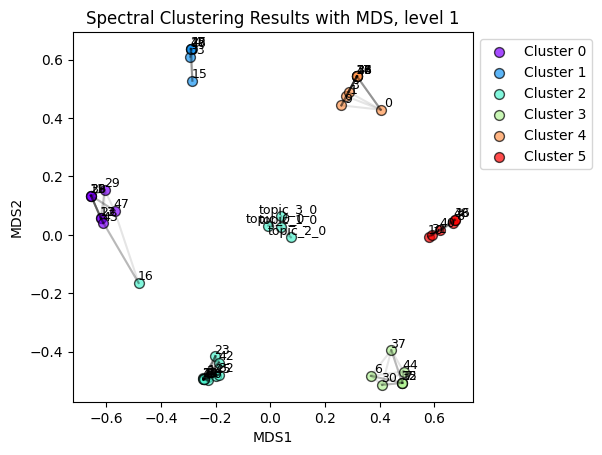

doc_names  \
11                   Chen_et_al._-_2018_-_fastp_an_ultra-fast_all-in-one_FASTQ_preprocessor   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
29                Mineeva_et_al._-_2020_-_DeepMAsED_evaluating_the_quality_of_metagenomic_a   
39  Rodríguez-Brazzarola_et_al._-_2018_-_Analyzing_the_Differences_Between_Reads_and_Contig   
43                Wagner_et_al._-_2022_-_Benchmarking_challenging_small_variants_with_linke   
47                 Zhang_et_al._-_2023_-_Review_of_single-cell_RNA-seq_data_clustering_for_   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
18              Florensa_et_al._-_2022_-_ResFinder_–_an_open_online_resource_for_identifica   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
33                Oehler_et_al._-_2023_-_The_application_of_long-read_sequencing_in_clinica   
45                         Wood_et_al._-_2019_-_Improved_metagenomic_analysis_with_Kraken_2   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
14                            Danecek_et_al._-_2021_-_Twelve_years_of_SAMtools_and_BCFtools   
19                                             Flynn_et_al._-_2023_-_Single-Cell_Multiomics   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
23                Li_and_Durbin_-_2009_-_Fast_and_accurate_short_read_alignment_with_Burrow   
24                   Lin_et_al._-_2017_-_Using_neural_networks_for_reducing_the_dimensions_   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
32             Nayak_and_Hasija_-_2021_-_A_hitchhiker's_guide_to_single-cell_transcriptomic   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti   
42                  Satam_et_al._-_2023_-_Next-Generation_Sequencing_Technology_Current_Tre   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
44            Wilton_and_Szalay_-_2023_-_Short-read_aligner_performance_in_germline_variant   
0               Alneberg_et_al._-_2014_-_Binning_metagenomic_contigs_by_coverage_and_compos   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
3              Anders_and_Huber_-_2010_-_Differential_expression_analysis_for_sequence_coun   
9               Brockley_et_al._-_2023_-_Sequence-Based_Platforms_for_Discovering_Biomarker   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
26                     Lu_et_al._-_2017_-_Bracken_estimating_species_abundance_in_metagenom   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
38               Roberto_et_al._-_2023_-_Strategies_for_improving_detection_of_circulating_ 

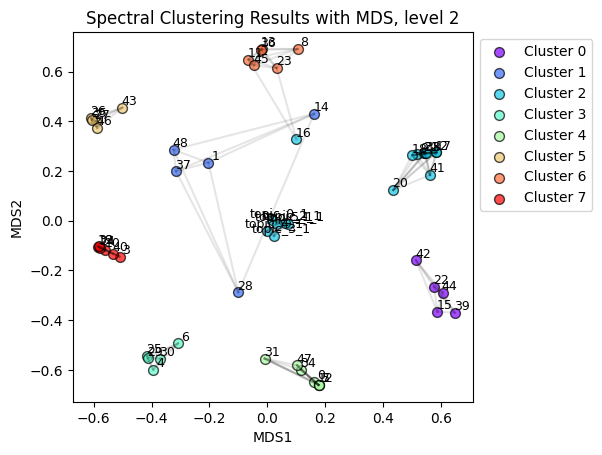

doc_names  \
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
39  Rodríguez-Brazzarola_et_al._-_2018_-_Analyzing_the_Differences_Between_Reads_and_Contig   
42                  Satam_et_al._-_2023_-_Next-Generation_Sequencing_Technology_Current_Tre   
44            Wilton_and_Szalay_-_2023_-_Short-read_aligner_performance_in_germline_variant   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
14                            Danecek_et_al._-_2021_-_Twelve_years_of_SAMtools_and_BCFtools   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
48                   Zhou_et_al._-_2018_-_GrapeTree_visualization_of_core_genomic_relations   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
9               Brockley_et_al._-_2023_-_Sequence-Based_Platforms_for_Discovering_Biomarker   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
18              Florensa_et_al._-_2022_-_ResFinder_–_an_open_online_resource_for_identifica   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
33                Oehler_et_al._-_2023_-_The_application_of_long-read_sequencing_in_clinica   
38               Roberto_et_al._-_2023_-_Strategies_for_improving_detection_of_circulating_   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
29                Mineeva_et_al._-_2020_-_DeepMAsED_evaluating_the_quality_of_metagenomic_a   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
0               Alneberg_et_al._-_2014_-_Binning_metagenomic_contigs_by_coverage_and_compos   
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
31                Navgire_et_al._-_2022_-_Analysis_and_Interpretation_of_metagenomics_data_   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
47                 Zhang_et_al._-_2023_-_Review_of_single-cell_RNA-seq_data_clustering_for_   
26                     Lu_et_al._-_2017_-_Bracken_estimating_species_abundance_in_metagenom   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
43                Wagner_et_al._-_2022_-_Benchmarking_challenging_small_variants_with_linke   
46                  Yang_et_al._-_2014_-_Application_of_Next-generation_Sequencing_Technolo   
8                   Bonin_et_al._-_2023_-_MEGARes_and_AMR++,_v3.0_an_updated_comprehensive_   
11                   Chen_et_al._-_2018_-_fastp_an_ultra-fast_all-in-one_FASTQ_preprocessor   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
23                Li_and_Durbin_-_2009_-_Fast_and_accurate_short_read_alignment_with_Burrow   
36               O’Toole_et_al._-_2021_-_Assignment_of_epidemiological_lineages_in_an_emerg 

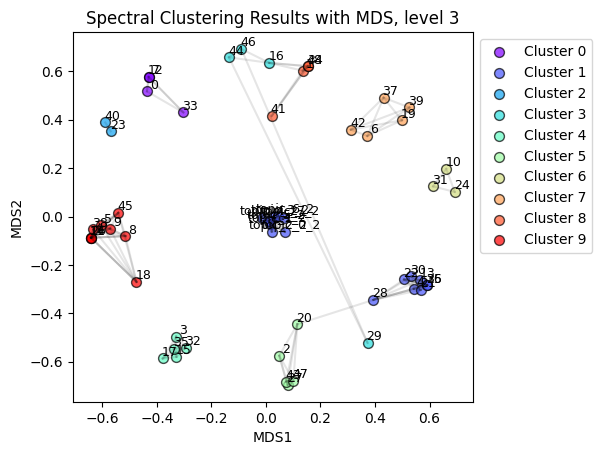

doc_names  \
0               Alneberg_et_al._-_2014_-_Binning_metagenomic_contigs_by_coverage_and_compos   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
33                Oehler_et_al._-_2023_-_The_application_of_long-read_sequencing_in_clinica   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
36               O’Toole_et_al._-_2021_-_Assignment_of_epidemiological_lineages_in_an_emerg   
23                Li_and_Durbin_-_2009_-_Fast_and_accurate_short_read_alignment_with_Burrow   
40                  Ross_et_al._-_2013_-_Characterizing_and_measuring_bias_in_sequence_data   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
29                Mineeva_et_al._-_2020_-_DeepMAsED_evaluating_the_quality_of_metagenomic_a   
44            Wilton_and_Szalay_-_2023_-_Short-read_aligner_performance_in_germline_variant   
46                  Yang_et_al._-_2014_-_Application_of_Next-generation_Sequencing_Technolo   
3              Anders_and_Huber_-_2010_-_Differential_expression_analysis_for_sequence_coun   
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
32             Nayak_and_Hasija_-_2021_-_A_hitchhiker's_guide_to_single-cell_transcriptomic   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
43                Wagner_et_al._-_2022_-_Benchmarking_challenging_small_variants_with_linke   
47                 Zhang_et_al._-_2023_-_Review_of_single-cell_RNA-seq_data_clustering_for_   
10                            Caudai_et_al._-_2021_-_AI_applications_in_functional_genomics   
24                   Lin_et_al._-_2017_-_Using_neural_networks_for_reducing_the_dimensions_   
31                Navgire_et_al._-_2022_-_Analysis_and_Interpretation_of_metagenomics_data_   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
19                                             Flynn_et_al._-_2023_-_Single-Cell_Multiomics   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
39  Rodríguez-Brazzarola_et_al._-_2018_-_Analyzing_the_Differences_Between_Reads_and_Contig   
42                  Satam_et_al._-_2023_-_Next-Generation_Sequencing_Technology_Current_Tre   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti   
48                   Zhou_et_al._-_2018_-_GrapeTree_visualization_of_core_genomic_relations   
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
8                   Bonin_et_al._-_2023_-_MEGARes_and_AMR++,_v3.0_an_updated_comprehensive_ 

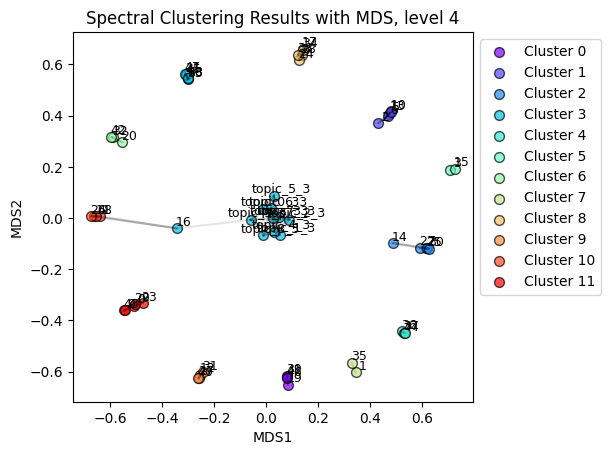

doc_names  \
19                                             Flynn_et_al._-_2023_-_Single-Cell_Multiomics   
39  Rodríguez-Brazzarola_et_al._-_2018_-_Analyzing_the_Differences_Between_Reads_and_Contig   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti   
46                  Yang_et_al._-_2014_-_Application_of_Next-generation_Sequencing_Technolo   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
10                            Caudai_et_al._-_2021_-_AI_applications_in_functional_genomics   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
14                            Danecek_et_al._-_2021_-_Twelve_years_of_SAMtools_and_BCFtools   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
33                Oehler_et_al._-_2023_-_The_application_of_long-read_sequencing_in_clinica   
45                         Wood_et_al._-_2019_-_Improved_metagenomic_analysis_with_Kraken_2   
47                 Zhang_et_al._-_2023_-_Review_of_single-cell_RNA-seq_data_clustering_for_   
48                   Zhou_et_al._-_2018_-_GrapeTree_visualization_of_core_genomic_relations   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
36               O’Toole_et_al._-_2021_-_Assignment_of_epidemiological_lineages_in_an_emerg   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
44            Wilton_and_Szalay_-_2023_-_Short-read_aligner_performance_in_germline_variant   
3              Anders_and_Huber_-_2010_-_Differential_expression_analysis_for_sequence_coun   
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
32             Nayak_and_Hasija_-_2021_-_A_hitchhiker's_guide_to_single-cell_transcriptomic   
42                  Satam_et_al._-_2023_-_Next-Generation_Sequencing_Technology_Current_Tre   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
18              Florensa_et_al._-_2022_-_ResFinder_–_an_open_online_resource_for_identifica   
24                   Lin_et_al._-_2017_-_Using_neural_networks_for_reducing_the_dimensions_   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
38               Roberto_et_al._-_2023_-_Strategies_for_improving_detection_of_circulating_   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
31                Navgire_et_al._-_2022_-_Analysis_and_Interpretation_of_metagenomics_data_   
40                  Ross_et_al._-_2013_-_Characterizing_and_measuring_bias_in_sequence_data   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
8                   Bonin_et_al._-_2023_-_MEGARes_and_AMR++,_v3.0_an_updated_comprehensive_ 

doc_names  \
0               Alneberg_et_al._-_2014_-_Binning_metagenomic_contigs_by_coverage_and_compos   
1                   Alser_et_al._-_2021_-_Technology_dictates_algorithms_recent_development   
2            Amarasinghe_et_al._-_2020_-_Opportunities_and_challenges_in_long-read_sequenci   
3              Anders_and_Huber_-_2010_-_Differential_expression_analysis_for_sequence_coun   
4                 Argimón_et_al._-_2016_-_Microreact_visualizing_and_sharing_data_for_genom   
5               Bankevich_et_al._-_2012_-_SPAdes_A_New_Genome_Assembly_Algorithm_and_Its_Ap   
6               Bertrand_et_al._-_2019_-_Hybrid_metagenomic_assembly_enables_high-resolutio   
7                 Bolyen_et_al._-_2019_-_Reproducible,_interactive,_scalable_and_extensible   
8                   Bonin_et_al._-_2023_-_MEGARes_and_AMR++,_v3.0_an_updated_comprehensive_   
9               Brockley_et_al._-_2023_-_Sequence-Based_Platforms_for_Discovering_Biomarker   
10                            Caudai_et_al._-_2021_-_AI_applications_in_functional_genomics   
11                   Chen_et_al._-_2018_-_fastp_an_ultra-fast_all-in-one_FASTQ_preprocessor   
12             Cingolani_et_al._-_2012_-_A_program_for_annotating_and_predicting_the_effect   
13                  Cole_et_al._-_2019_-_Performance_Assessment_and_Selection_of_Normalizat   
14                            Danecek_et_al._-_2021_-_Twelve_years_of_SAMtools_and_BCFtools   
15                  Ding_et_al._-_2018_-_Interpretable_dimensionality_reduction_of_single_c   
16                  Ewels_et_al._-_2016_-_MultiQC_summarize_analysis_results_for_multiple_t   
17            Feldgarden_et_al._-_2021_-_AMRFinderPlus_and_the_Reference_Gene_Catalog_facil   
18              Florensa_et_al._-_2022_-_ResFinder_–_an_open_online_resource_for_identifica   
19                                             Flynn_et_al._-_2023_-_Single-Cell_Multiomics   
20        Ibañez-Lligoña_et_al._-_2023_-_Bioinformatic_Tools_for_NGS-Based_Metagenomics_to_   
21             Kishikawa_et_al._-_2019_-_Empirical_evaluation_of_variant_calling_accuracy_u   
22                           Li_-_2014_-_Toward_better_understanding_of_artifacts_in_varian   
23                Li_and_Durbin_-_2009_-_Fast_and_accurate_short_read_alignment_with_Burrow   
24                   Lin_et_al._-_2017_-_Using_neural_networks_for_reducing_the_dimensions_   
25                   Liu_et_al._-_2021_-_A_practical_guide_to_amplicon_and_metagenomic_anal   
26                     Lu_et_al._-_2017_-_Bracken_estimating_species_abundance_in_metagenom   
27                McInnes_et_al._-_2020_-_UMAP_Uniform_Manifold_Approximation_and_Projectio   
28                McKenna_et_al._-_2010_-_The_Genome_Analysis_Toolkit_A_MapReduce_framework   
29                Mineeva_et_al._-_2020_-_DeepMAsED_evaluating_the_quality_of_metagenomic_a   
30                    Nam_et_al._-_2023_-_Metagenomics_An_Effective_Approach_for_Exploring_   
31                Navgire_et_al._-_2022_-_Analysis_and_Interpretation_of_metagenomics_data_   
32             Nayak_and_Hasija_-_2021_-_A_hitchhiker's_guide_to_single-cell_transcriptomic   
33                Oehler_et_al._-_2023_-_The_application_of_long-read_sequencing_in_clinica   
34                  Ondov_et_al._-_2016_-_Mash_fast_genome_and_metagenome_distance_estimati   
35       O’Connor_and_Heyderman_-_2023_-_The_challenges_of_defining_the_human_nasopharyngea   
36               O’Toole_et_al._-_2021_-_Assignment_of_epidemiological_lineages_in_an_emerg   
37                    Reinert_et_al._-_2015_-_Alignment_of_Next-Generation_Sequencing_Reads   
38               Roberto_et_al._-_2023_-_Strategies_for_improving_detection_of_circulating_   
39  Rodríguez-Brazzarola_et_al._-_2018_-_Analyzing_the_Differences_Between_Reads_and_Contig   
40                  Ross_et_al._-_2013_-_Characterizing_and_measuring_bias_in_sequence_data   
41              Roumpeka_et_al._-_2017_-_A_Review_of_Bioinformatics_Tools_for_Bio-Prospecti 

In [68]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
agg_clusters = None
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(model.get_level(level_id), doc_names=doc_names, labels=labels)
    if level_id == 0:
        agg_clusters = df[['doc_names', 'cluster_id']].rename(columns={'cluster_id':'cluster_id_0'})
    else:
        agg_clusters[f'cluster_id_{level_id}'] = df['cluster_id']
    sorted_df = df.sort_values(by=['cluster_id', 'max_p_topic_id'])
    display(sorted_df)
    plot_sankey(sorted_df, title=f'Sankey plot for clustering results and top-P topic id for level {level_id}.')
display(agg_clusters)
plot_full_sankey(agg_clusters)

### Figure 5. Topic hierarchy structure - bioinformatics dataset

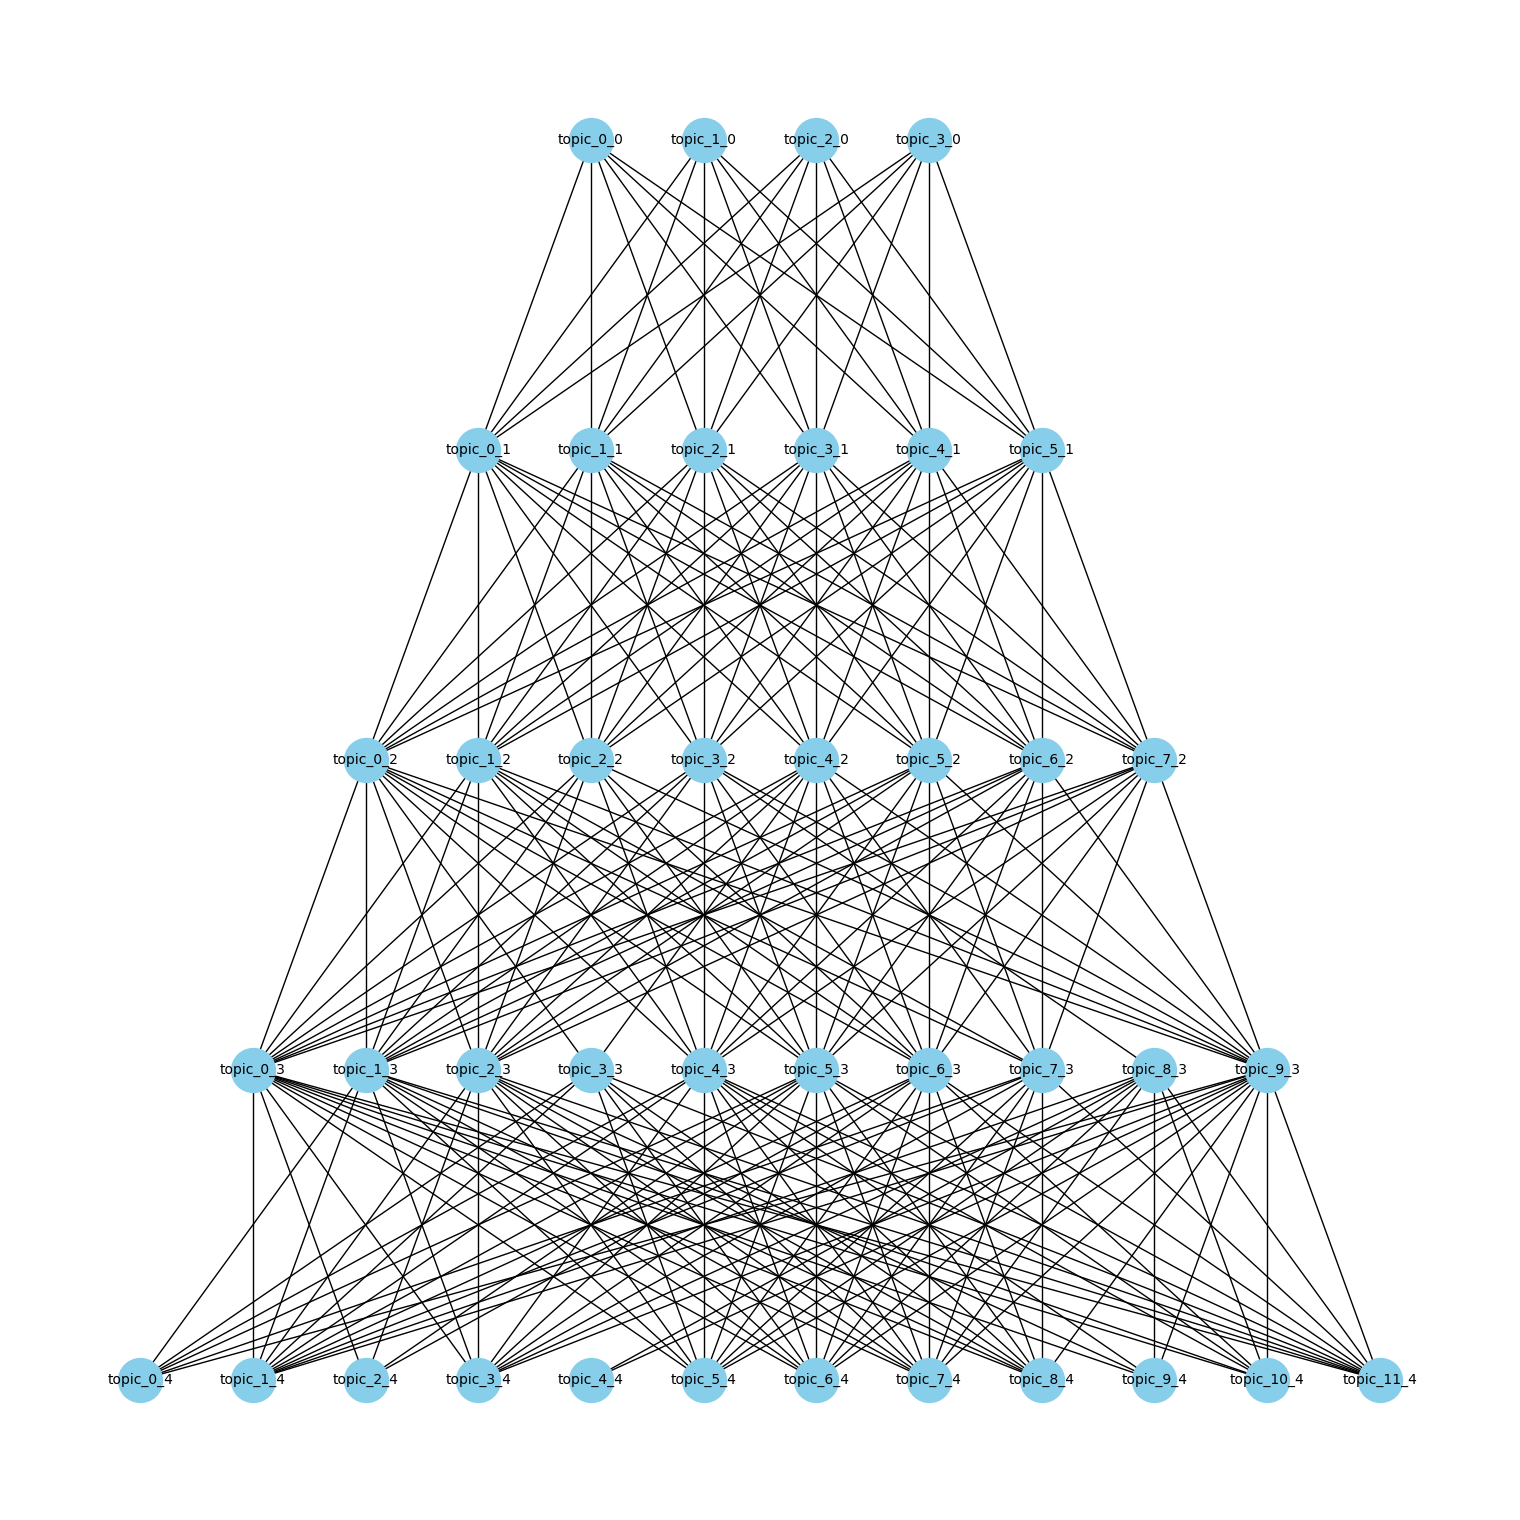

In [69]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(model, num_levels, threshold=0.05)

# Results for NLP set

In [70]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [71]:
#Preparing list of document names
with open(f'{input_folder}nlp_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

In [72]:
#Number of topics
num_levels = 4
topics_per_level = [2, 4, 8, 12] #should be increasing with index

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [73]:
%%time
#Training the model
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 1min 23s, sys: 22.3 s, total: 1min 46s
Wall time: 38.5 s


In [74]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(model, num_levels)


level0

topic_0:  ['natural_language', 'language_processing', 'computational_linguistics', 'association_computational', 'international_conference', 'machine_learning', 'social_media', 'concept_extraction', 'deep_learning', 'proceedings_conference']
topic_1:  ['machine_learning', 'international_conference', 'network_embedding', 'computer_science', 'deep_learning', 'natural_language', 'association_computational', 'computational_linguistics', 'information_processing', 'language_processing']

level1

topic_0:  ['text_mining', 'spam_detection', 'clinical_trial', 'social_spam', 'dream_reports', 'clinical_trials', 'argument_mining', 'natural_language', 'social_networks', 'international_conference']
topic_1:  ['natural_language', 'language_processing', 'computational_linguistics', 'concept_extraction', 'association_computational', 'international_conference', 'proceedings_conference', 'machine_learning', 'anaphora_resolution', 'deep_learning']
topic_2:  ['social_media', 'data_set', 'informatio

### Figure 6. Quality metrics accross training iterations for hierarchical model - bioinformatics dataset


Results for level 0

Sparsity Phi: 0.471 
Sparsity Theta: 0.020
Kernel contrast: 0.961
Kernel purity: 0.963


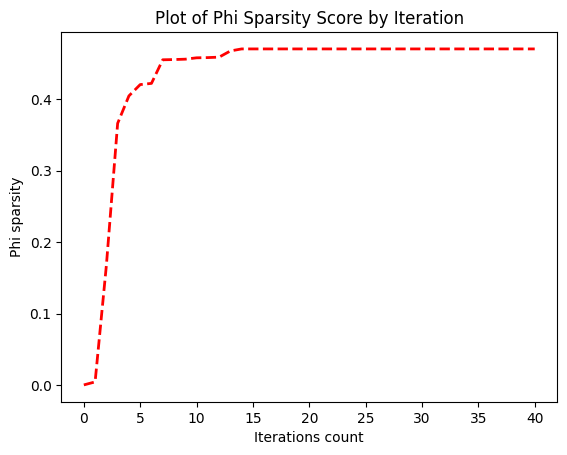

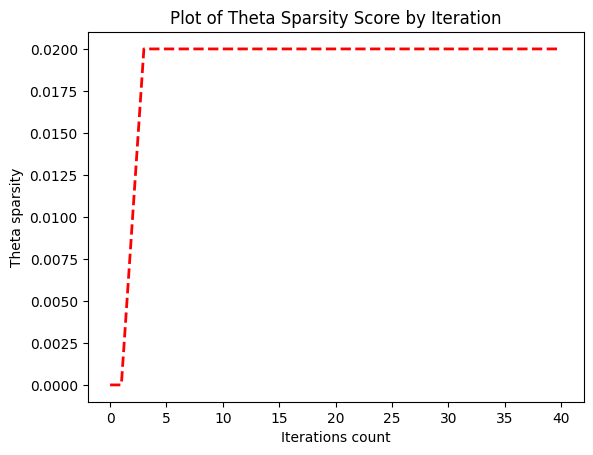

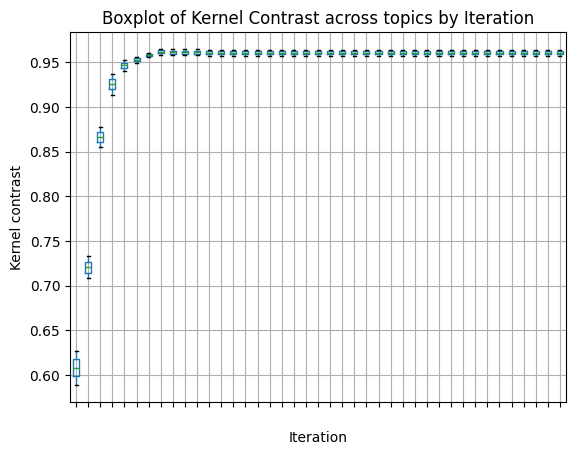

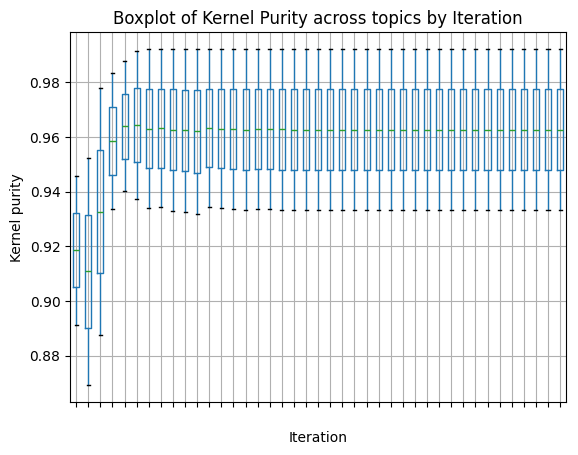

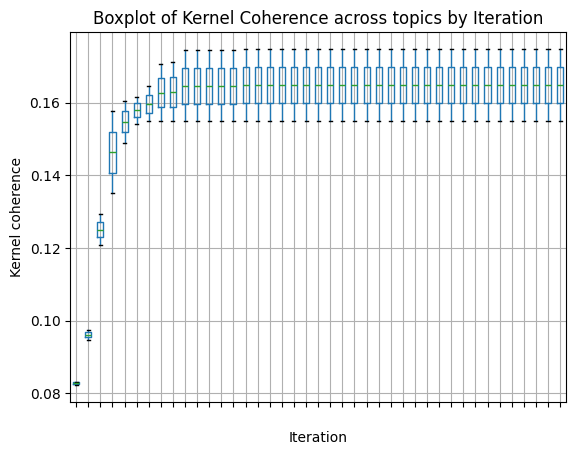


Results for level 1

Sparsity Phi: 0.713 
Sparsity Theta: 0.053
Kernel contrast: 0.944
Kernel purity: 0.914


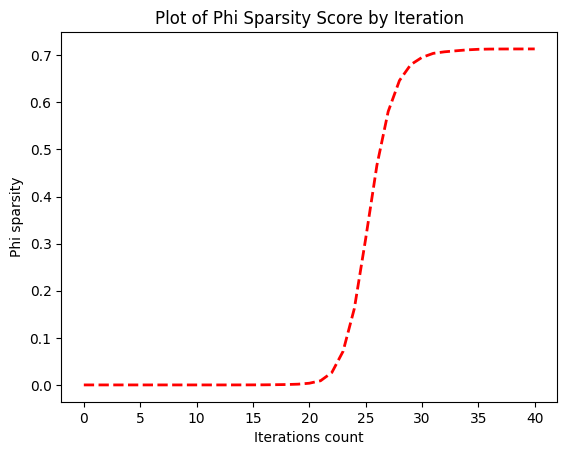

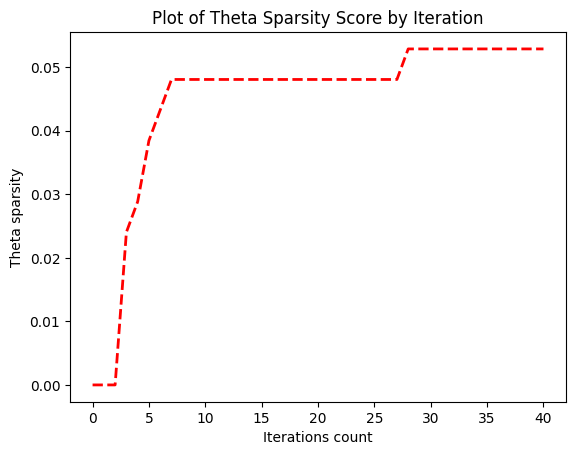

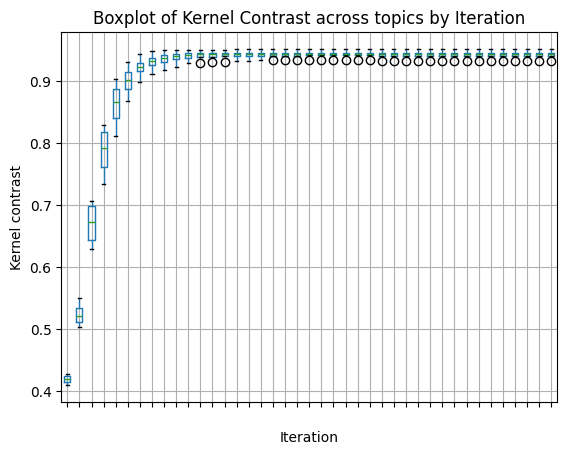

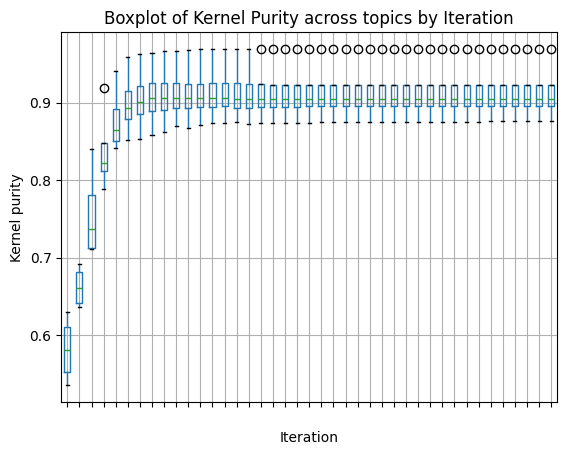

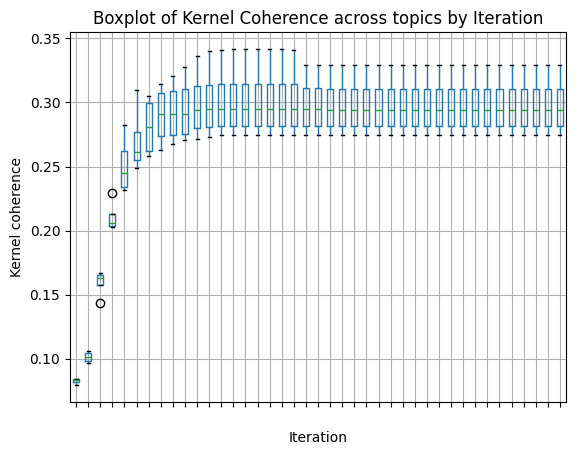


Results for level 2

Sparsity Phi: 0.837 
Sparsity Theta: 0.155
Kernel contrast: 0.941
Kernel purity: 0.915


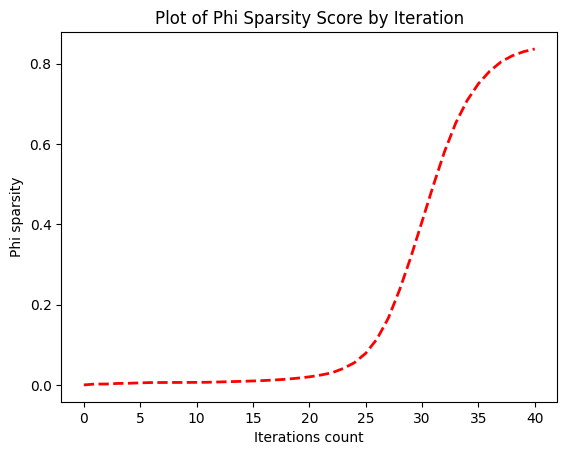

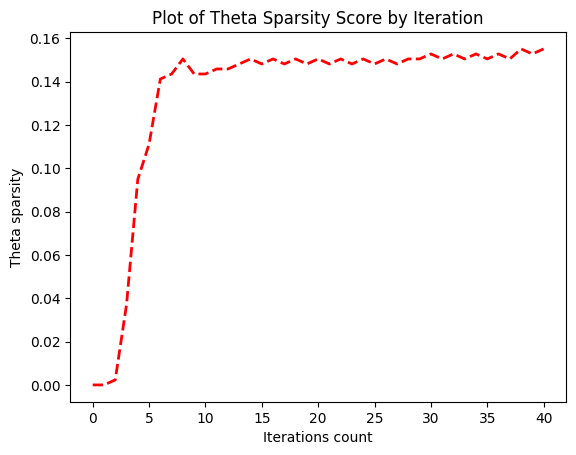

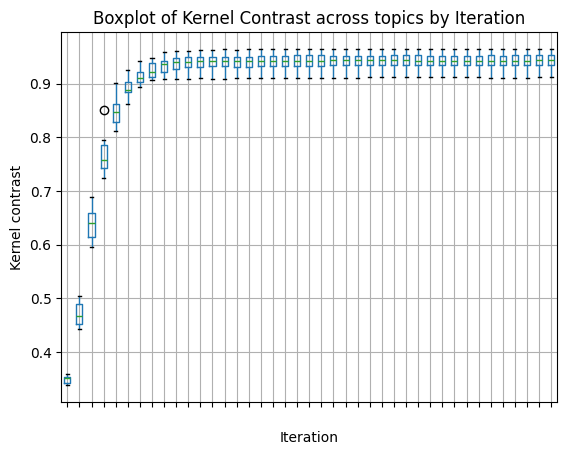

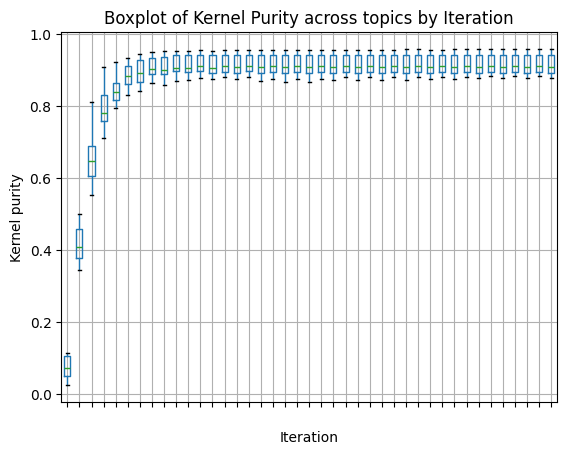

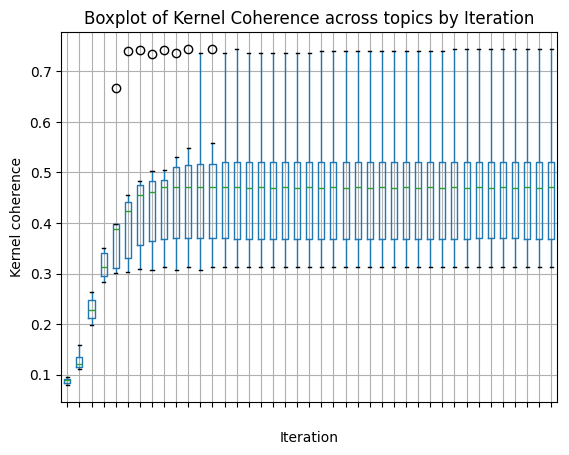


Results for level 3

Sparsity Phi: 0.000 
Sparsity Theta: 0.000
Kernel contrast: 0.518
Kernel purity: 0.525


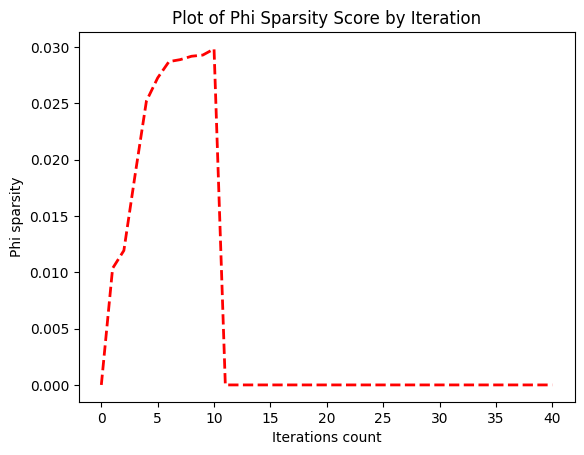

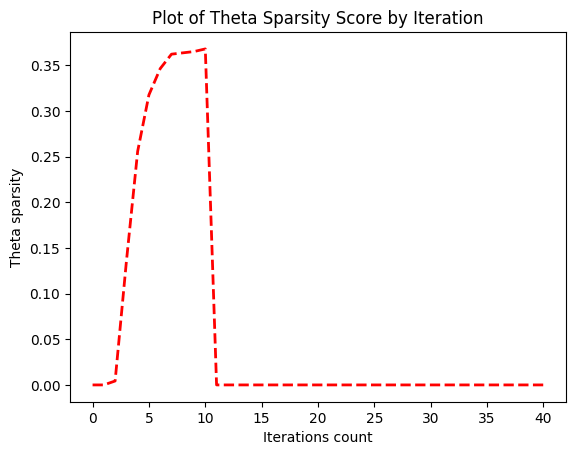

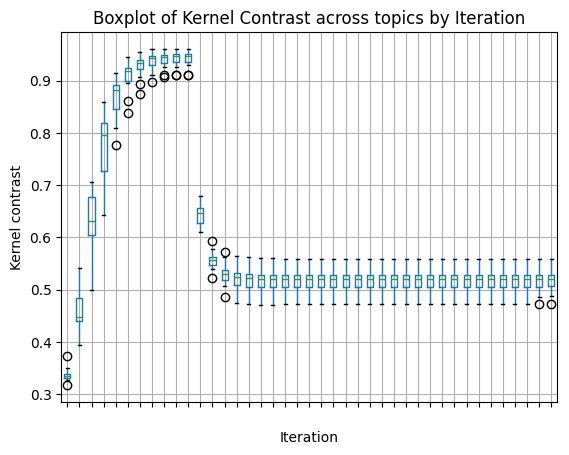

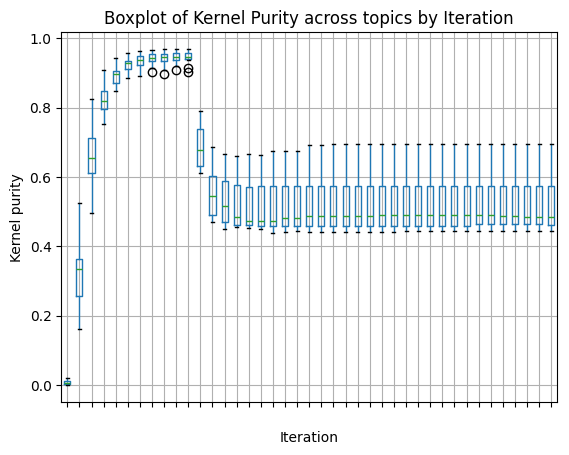

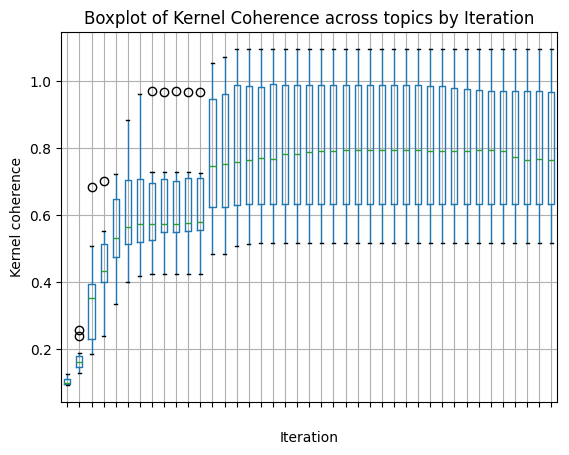

In [75]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(model.get_level(level_id))

### Figure 7. Spectral clustering results - NLP dataset

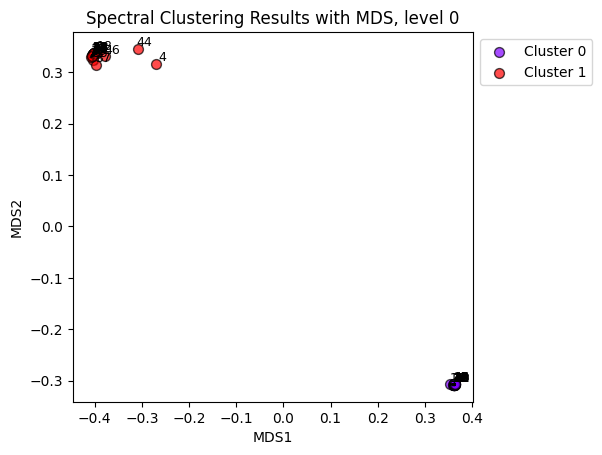

doc_names  \
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc   
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic   
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr   
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod   
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction   
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and   
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification   
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review   
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl   
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex   
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome   
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar   
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk   
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure   
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex   
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models   
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_   
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques   
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_   
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur   
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi   
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope   
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa   
47               Zhao_et_al._-_2021_-_Entropy-aware_self-training_for_graph_convolutiona   
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label   
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system   
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review   
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit   
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l   
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas   
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect   
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s   
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease   
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-   
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl   
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l   
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now   
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui   
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu   
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp   
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local   
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis   
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question   
37     Paolanti_and_Frontoni_-_

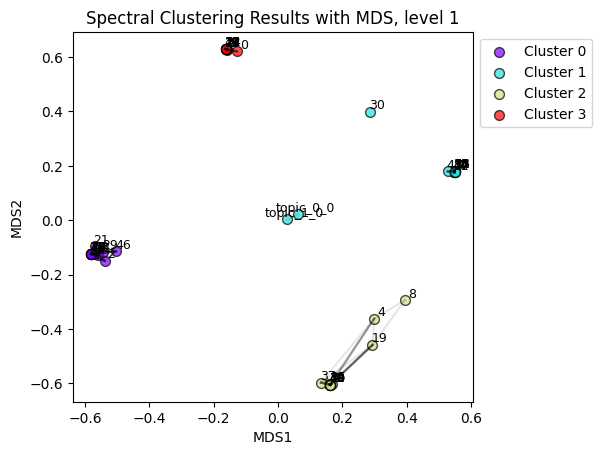

doc_names  \
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic   
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod   
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification   
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease   
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l   
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now   
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp   
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk   
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models   
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur   
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor   
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_   
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc   
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label   
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas   
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review   
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl   
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex   
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar   
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure   
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_   
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques   
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_   
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question   
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey   
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa   
47               Zhao_et_al._-_2021_-_Entropy-aware_self-training_for_graph_convolutiona   
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review   
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit   
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l   
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction   
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect   
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl   
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome   
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis   
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications   
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data   
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi   
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati   
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system   
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc   
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr   
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and   
13        Fuenteslópez_et_al._-

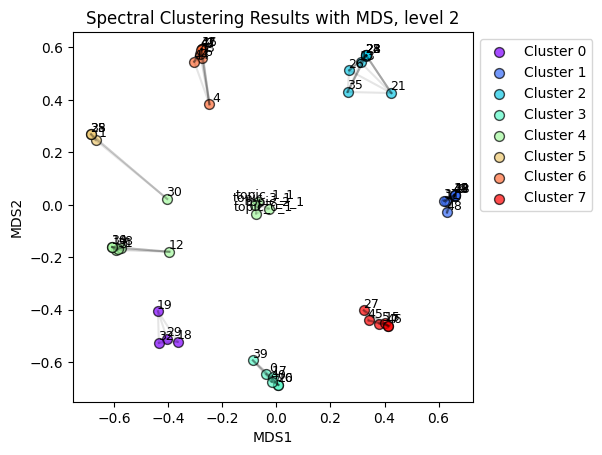

doc_names  \
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl   
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome   
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models   
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_   
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and   
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification   
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease   
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur   
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications   
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor   
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label   
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system   
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s   
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now   
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui   
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar   
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu   
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk   
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex   
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis   
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc   
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex   
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-   
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l   
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi   
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope   
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr   
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction   
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect   
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review   
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques   
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local   
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_   
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review   
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp   
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data   
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic   
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit   
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l   
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question   
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati   
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_   
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey   
47               Zhao_et_al._-_

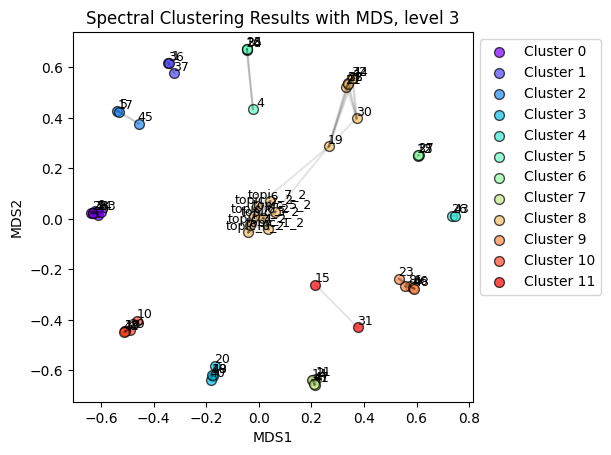

doc_names  \
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc   
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr   
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas   
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and   
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu   
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex   
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur   
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review   
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question   
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications   
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod   
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-   
45               Wang_et_al._-_2022_-_Deep_learning_modeling_of_public’s_sentiments_towa   
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl   
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l   
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope   
49       Zulkarnain_and_Putri_-_2021_-_Intelligent_transportation_systems_(ITS)_A_system   
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk   
43  Timmerman_and_Bronselaer_-_2022_-_Automated_monitoring_of_online_news_accuracy_with_   
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit   
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex   
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp   
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local   
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review   
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure   
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis   
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic   
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification   
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease   
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati   
47               Zhao_et_al._-_2021_-_Entropy-aware_self-training_for_graph_convolutiona   
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome   
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now   
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui   
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_   
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_   
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data   
44                         Wang_et_al._-_2021_-_Knowledge_graph_quality_control_A_survey   
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l   
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction   
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar   
46             Zangari_et_al._-_2023_-_Ticket_automation_An_insight_into_current_researc   
48                Zhao_et_al._-_2023_-_Weak-PMLC_A_large-scale_framework_for_multi-label   
10        Di_Girolamo_et_al._-_

doc_names  \
0       Accuosto_and_Saggion_-_2020_-_Mining_arguments_in_scientific_abstracts_with_disc   
1                Amara_et_al._-_2021_-_Network_representation_learning_systematic_review   
2             Babaiha_et_al._-_2023_-_A_natural_language_processing_system_for_the_effic   
3                Baek_et_al._-_2021_-_A_critical_review_of_text-based_research_in_constr   
4   Bondielli_and_Marcelloni_-_2021_-_On_the_use_of_summarization_and_transformer_archit   
5            Curiskis_et_al._-_2020_-_An_evaluation_of_document_clustering_and_topic_mod   
6             D'Ercole_et_al._-_2022_-_Classifying_news_articles_in_multiple_languages_l   
7           De_Clercq_et_al._-_2019_-_Multi-label_classification_and_interactive_NLP-bas   
8                                Detroja_et_al._-_2023_-_A_survey_on_Relation_Extraction   
9               Dhayne_et_al._-_2021_-_EMR2vec_Bridging_the_gap_between_patient_data_and   
10        Di_Girolamo_et_al._-_2021_-_Evolutionary_game_theoretical_on-line_event_detect   
11               Doan_and_Gulla_-_2022_-_A_Survey_on_Political_Viewpoints_Identification   
12                   Fu_et_al._-_2020_-_Clinical_concept_extraction_A_methodology_review   
13        Fuenteslópez_et_al._-_2023_-_Biomaterials_text_mining_A_hands-on_comparative_s   
14   García_del_Valle_et_al._-_2019_-_Disease_networks_and_their_contribution_to_disease   
15        García-Díaz_et_al._-_2020_-_Ontology-driven_aspect-based_sentiment_analysis_cl   
16           Giordano_et_al._-_2023_-_Unveiling_the_inventive_process_from_patents_by_ex   
17        Gutman_Music_et_al._-_2022_-_Mapping_dreams_in_a_computational_space_A_phrase-   
18    Haneczok_and_Piskorski_-_2020_-_Shallow_and_deep_learning_for_event_relatedness_cl   
19           Harnoune_et_al._-_2021_-_BERT_based_clinical_knowledge_extraction_for_biome   
20           Ilievski_et_al._-_2020_-_The_role_of_knowledge_in_determining_identity_of_l   
21                Jain_et_al._-_2021_-_Summarization_of_legal_documents_Where_are_we_now   
22               Jain_et_al._-_2023_-_Bayesian_Optimization_based_Score_Fusion_of_Lingui   
23      Jáñez-Martino_et_al._-_2023_-_Classifying_spam_emails_using_agglomerative_hierar   
24             Kumar_and_III_-_2011_-_A_Co-training_Approach_for_Multi-view_Spectral_Clu   
25            Lathabai_et_al._-_2022_-_Institutional_collaboration_recommendation_An_exp   
26                 Li_et_al._-_2021_-_Can_social_media_data_be_used_to_evaluate_the_risk   
27                 Li_et_al._-_2022_-_Neural_Natural_Language_Processing_for_unstructure   
28                Lupi_et_al._-_2023_-_Automatic_definition_of_engineer_archetypes_A_tex   
29               Lytos_et_al._-_2019_-_The_evolution_of_argumentation_mining_From_models   
30         López-Úbeda_et_al._-_2022_-_Natural_Language_Processing_in_Pathology_Current_   
31                        Mao_et_al._-_2024_-_A_survey_on_semantic_processing_techniques   
32          Marchesin_et_al._-_2022_-_Empowering_digital_pathology_applications_through_   
33                May_et_al._-_2022_-_Applying_Natural_Language_Processing_in_Manufactur   
34         Medić_and_Šnajder_-_2022_-_An_empirical_study_of_the_design_choices_for_local   
35               Oral_et_al._-_2020_-_Information_Extraction_from_Text_Intensive_and_Vis   
36             Othman_et_al._-_2019_-_Enhancing_Question_Retrieval_in_Community_Question   
37     Paolanti_and_Frontoni_-_2020_-_Multidisciplinary_Pattern_Recognition_applications   
38         Pisaneschi_et_al._-_2023_-_Automatic_generation_of_scientific_papers_for_data   
39        Pérez-Pérez_et_al._-_2023_-_A_novel_gluten_knowledge_base_of_potential_biomedi   
40                 Rao_et_al._-_2021_-_A_review_on_social_spam_detection_Challenges,_ope   
41             Ruijie_et_al._-_2021_-_Patent_text_modeling_strategy_and_its_classificati   
42       Strąk_and_Tuszyński_-_2020_-_Quantitative_analysis_of_a_private_tax_rulings_cor   
43  Timmerman_and_Bronselaer_-_

In [76]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
agg_clusters = None
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(model.get_level(level_id), doc_names=doc_names, labels=labels)
    if level_id == 0:
        agg_clusters = df[['doc_names', 'cluster_id']].rename(columns={'cluster_id':'cluster_id_0'})
    else:
        agg_clusters[f'cluster_id_{level_id}'] = df['cluster_id']
    sorted_df = df.sort_values(by=['cluster_id', 'max_p_topic_id'])
    display(sorted_df)
    plot_sankey(sorted_df, title=f'Sankey plot for clustering results and top-P topic id for level {level_id}.')
display(agg_clusters)
plot_full_sankey(agg_clusters)

### Figure 8. Topic hierarchy structure - NLP dataset

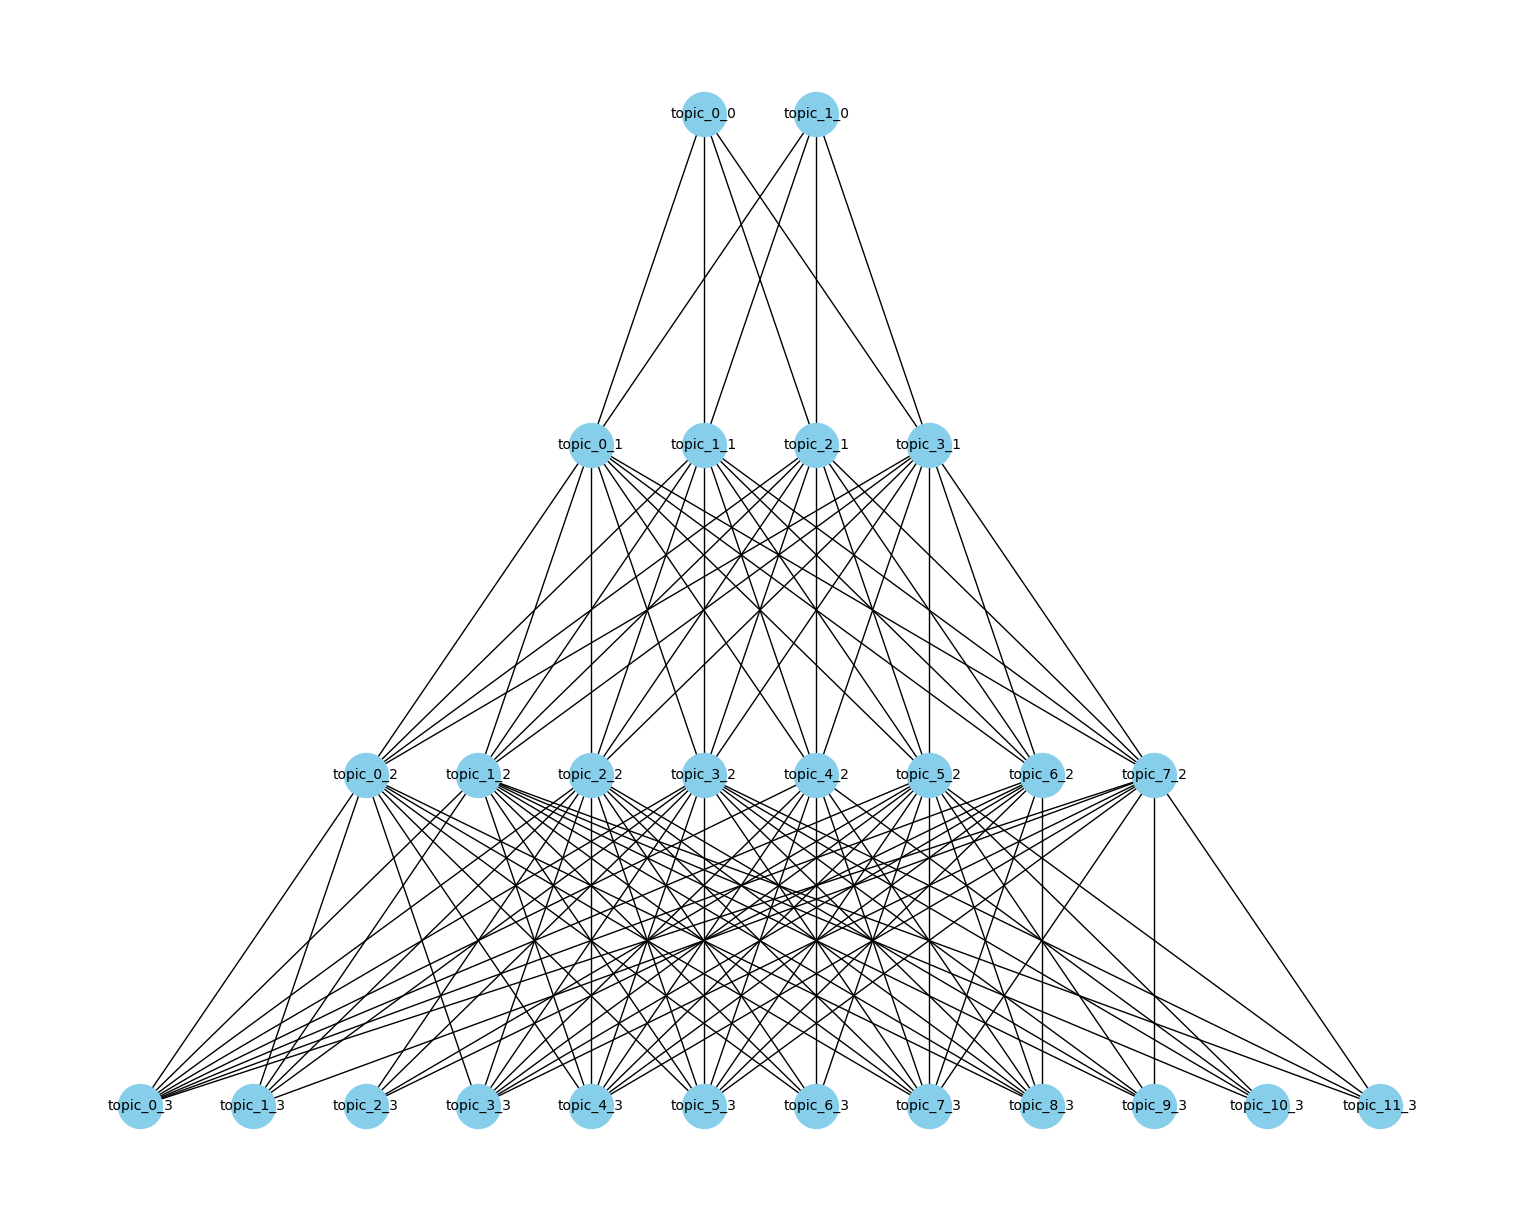

In [77]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(model, num_levels, threshold=0.05)

# Attempting to optimize parameters using randomized grid search

In [42]:
def random_combinations(parameter_ranges, n_iter=100):
    '''
    Given iterable of parameter ranges, creates a list of specific values to try
    in single iteration of optimization process using random sampling.
    '''
    # Calculate the total number of possible combinations
    total_combinations = np.prod([len(range_) for range_ in parameter_ranges])
    
    # Adjust n_iter based on the total number of possible combinations
    n_iter_adjusted = min(n_iter, total_combinations)
    
    # Generate combinations
    if n_iter_adjusted == total_combinations:
        # If we need all combinations, generate them directly
        all_combos = list(itertools.product(*parameter_ranges))
        random.shuffle(all_combos)  # Shuffle to introduce randomness
        selected_combos = all_combos[:n_iter_adjusted]
    else:
        # Generate unique combinations up to n_iter_adjusted
        selected_combos = set()
        while len(selected_combos) < n_iter_adjusted:
            combo = tuple(random.choice(range_) for range_ in parameter_ranges)
            selected_combos.add(combo)
        selected_combos = list(selected_combos)
    
    # Convert tuples back to lists
    return [list(combo) for combo in selected_combos]


def custom_cross_validation_randomized_hartm(
    batch_vectorizer, 
    dictionary, 
    scores, 
    regularizers, 
    num_levels, 
    parameter_ranges, 
    n_iter=100):
    '''
    Cross validation wrapper to train the model for n_iter itrations using unique, randomly chosen combinations of
    parameters in an attempt to find the combination that gives better results.
    '''
    parameter_combinations = random_combinations(parameter_ranges, n_iter)
    
    best_fitness = -np.inf
    best_params = None
    metrics = [[],[]]  # Store metrics for each iteration

    # Iterate over all parameter combinations directly, without parallel processing
    for params in parameter_combinations:
        # Unpack params into separate dictionaries for each training session
        tau_dicts = [{'SparsePhi': params[i], 'SparseTheta': params[i+1], 'DecorrelatorPhi': params[i+2]} for i in range(0, len(params) - num_levels, 3)]
        topics_per_level = params[-num_levels:]
        if len(tau_dicts) < 4:
            raise ValueError("Not enough tau_dicts provided for all training sessions.")
        
        # Adjust the call to train_hier_tm based on your function definition
        model_artm, flat_params, fitness, parameters, mean_S_qR = train_hier_tm(
            batch_vectorizer=batch_vectorizer,
            dictionary=dictionary,
            scores=scores,
            regularizers=regularizers,
            num_levels=num_levels,
            topics_per_level=topics_per_level,
            n1=10,  # Adjust as needed
            tau_dict_1=tau_dicts[0],
            n2=10,  # Adjust as needed
            tau_dict_2=tau_dicts[1],
            n3=10,  # Adjust as needed
            tau_dict_3=tau_dicts[2],
            n4=10,  # Adjust as needed
            tau_dict_4=tau_dicts[3],
        )
        
        # Aggregating metricts to visualize training progress
        metrics[0].append(mean_S_qR)
        metrics[1].append(fitness)
        
        # Update the best parameters if the current fitness is better
        if fitness > best_fitness:
            best_fitness = fitness
            best_params = flat_params
            best_model = model_artm
            print(f'New best fitness: {best_fitness} with params: {best_params}')
    
    # Extract mean_S_qR and fitness values
    iterations = list(range(1, len(metrics[0]) + 1))

    # Create bar chart
    fig = go.Figure()
    fig.add_trace(go.Line(x=iterations, y=metrics[0], name='Mean S_qR'))
    fig.add_trace(go.Line(x=iterations, y=metrics[1], name='Fitness'))

    # Customize appearance
    fig.update_layout(
        title='Model Metrics Over Iterations',
        xaxis_title='Iteration',
        yaxis_title='Metric Value',
        barmode='group'
    )

    # Show plot
    fig.show()
    return best_params, best_fitness, best_model

# Parameter optimization for NLP set

In [ ]:
%%time
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

#Preparing list of document names
with open(f'{input_folder}nlp_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

#Number of topics
num_levels = 4

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
        ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

# Number of optimization iterations
n_iter = 50

# Define ranges for regularization parameters
# Note: Adjust these ranges based on your domain knowledge and preliminary experiments

# SparsePhi range: Encourages sparsity in the word-topic distribution
sparse_phi_range = np.linspace(-1.0, 0, n_iter).tolist()  # Example: 10 values from -1.0 to 0

# SparseTheta range: Encourages sparsity in the topic-document distribution
sparse_theta_range = np.linspace(-1.0, 0, n_iter).tolist()  # Example: 10 values from -1.0 to 0

# DecorrelatorPhi range: Encourages topics to be different from each other
decorrelator_phi_range = np.logspace(4, 6, n_iter).tolist()  # Example: 10 logarithmically spaced values from 10^4 to 10^6



# Level 1 topic range
lev1_tr = np.round(np.linspace(1, 2, n_iter)).astype(int).tolist()
# Level 2 topic range
lev2_tr = np.round(np.linspace(3, 8, n_iter)).astype(int).tolist()
# Level 3 topic range
lev3_tr = np.round(np.linspace(9, 12, n_iter)).astype(int).tolist()
# Level 4 topic range
lev4_tr = np.round(np.linspace(13, 16, n_iter)).astype(int).tolist()


# Assuming 4 sessions, each needing values for SparsePhi, SparseTheta, and DecorrelatorPhi
parameter_ranges = [
    sparse_phi_range,  # SparsePhi for session 1
    sparse_theta_range,  # SparseTheta for session 1
    decorrelator_phi_range,  # DecorrelatorPhi for session 1
    sparse_phi_range,  # SparsePhi for session 2
    sparse_theta_range,  # SparseTheta for session 2
    decorrelator_phi_range,  # DecorrelatorPhi for session 2
    sparse_phi_range,  # SparsePhi for session 3
    sparse_theta_range,  # SparseTheta for session 3
    decorrelator_phi_range,  # DecorrelatorPhi for session 3
    sparse_phi_range,  # SparsePhi for session 4
    sparse_theta_range,  # SparseTheta for session 4
    decorrelator_phi_range,  # DecorrelatorPhi for session 4
    lev1_tr, # Range for number of topics at level 1
    lev2_tr, # Range for number of topics at level 2
    lev3_tr, # Range for number of topics at level 3
    lev4_tr, # Range for number of topics at level 4
]




# Execute the optimization function
best_params, best_fitness, best_model = custom_cross_validation_randomized_hartm(
    batch_vectorizer=batch_vectorizer,
    dictionary=cooc_dict,
    scores=scores,
    regularizers=regularizers,
    num_levels=num_levels,
    parameter_ranges=parameter_ranges,
    n_iter=n_iter  # Number of iterations for the random search
)

print(f"Best Parameters: {best_params}")
print(f"Best Fitness: {best_fitness}")

In [ ]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(best_model, num_levels)

In [ ]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(best_model.get_level(level_id))

### Figure 7. Spectral clustering results - NLP dataset

In [ ]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
agg_clusters = None
for level_id in range(num_levels):
    dm = get_distance_matrix(best_model, level_id)
    labels = get_spectral_clusters(dm,best_params[-num_levels:][level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(best_model.get_level(level_id), doc_names=doc_names, labels=labels)
    if level_id == 0:
        agg_clusters = df[['doc_names', 'cluster_id']].rename(columns={'cluster_id':'cluster_id_0'})
    else:
        agg_clusters[f'cluster_id_{level_id}'] = df['cluster_id']
    sorted_df = df.sort_values(by=['cluster_id', 'max_p_topic_id'])
    display(sorted_df)
    plot_sankey(sorted_df, title=f'Sankey plot for clustering results and top-P topic id for level {level_id}.')
display(agg_clusters)
plot_full_sankey(agg_clusters)

### Figure 8. Topic hierarchy structure - NLP dataset

In [ ]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(best_model, num_levels, threshold=0.05)

# Parameter optimization - BIOIT set

In [ ]:
%%time
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

#Preparing list of document names
with open(f'{input_folder}bioit_set_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

#Number of topics
num_levels = 4

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=-10), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
        ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10


# Number of optimization iterations
n_iter = 50

# Define ranges for regularization parameters
# Note: Adjust these ranges based on your domain knowledge and preliminary experiments

# SparsePhi range: Encourages sparsity in the word-topic distribution
sparse_phi_range = np.linspace(-1.0, 0, n_iter).tolist()  # Example: 10 values from -1.0 to 0

# SparseTheta range: Encourages sparsity in the topic-document distribution
sparse_theta_range = np.linspace(-1.0, 0, n_iter).tolist()  # Example: 10 values from -1.0 to 0

# DecorrelatorPhi range: Encourages topics to be different from each other
decorrelator_phi_range = np.logspace(4, 6, n_iter).tolist()  # Example: 10 logarithmically spaced values from 10^4 to 10^6



# Level 1 topic range
lev1_tr = np.round(np.linspace(1, 2, n_iter)).astype(int).tolist()
# Level 2 topic range
lev2_tr = np.round(np.linspace(3, 8, n_iter)).astype(int).tolist()
# Level 3 topic range
lev3_tr = np.round(np.linspace(9, 12, n_iter)).astype(int).tolist()
# Level 4 topic range
lev4_tr = np.round(np.linspace(13, 16, n_iter)).astype(int).tolist()


# Assuming 4 sessions, each needing values for SparsePhi, SparseTheta, and DecorrelatorPhi
parameter_ranges = [
    sparse_phi_range,  # SparsePhi for session 1
    sparse_theta_range,  # SparseTheta for session 1
    decorrelator_phi_range,  # DecorrelatorPhi for session 1
    sparse_phi_range,  # SparsePhi for session 2
    sparse_theta_range,  # SparseTheta for session 2
    decorrelator_phi_range,  # DecorrelatorPhi for session 2
    sparse_phi_range,  # SparsePhi for session 3
    sparse_theta_range,  # SparseTheta for session 3
    decorrelator_phi_range,  # DecorrelatorPhi for session 3
    sparse_phi_range,  # SparsePhi for session 4
    sparse_theta_range,  # SparseTheta for session 4
    decorrelator_phi_range,  # DecorrelatorPhi for session 4
    lev1_tr, # Range for number of topics at level 1
    lev2_tr, # Range for number of topics at level 2
    lev3_tr, # Range for number of topics at level 3
    lev4_tr, # Range for number of topics at level 4
]




# Execute the optimization function
best_params, best_fitness, best_model = custom_cross_validation_randomized_hartm(
    batch_vectorizer=batch_vectorizer,
    dictionary=cooc_dict,
    scores=scores,
    regularizers=regularizers,
    num_levels=num_levels,
    parameter_ranges=parameter_ranges,
    n_iter=n_iter  # Number of iterations for the random search
)

print(f"Best Parameters: {best_params}")
print(f"Best Fitness: {best_fitness}")

In [ ]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(best_model, num_levels)

In [ ]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(best_model.get_level(level_id))

### Figure 7. Spectral clustering results - BIT dataset

In [ ]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
agg_clusters = None
for level_id in range(num_levels):
    dm = get_distance_matrix(best_model, level_id)
    labels = get_spectral_clusters(dm,best_params[-num_levels:][level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(best_model.get_level(level_id), doc_names=doc_names, labels=labels)
    if level_id == 0:
        agg_clusters = df[['doc_names', 'cluster_id']].rename(columns={'cluster_id':'cluster_id_0'})
    else:
        agg_clusters[f'cluster_id_{level_id}'] = df['cluster_id']
    sorted_df = df.sort_values(by=['cluster_id', 'max_p_topic_id'])
    display(sorted_df)
    plot_sankey(sorted_df, title=f'Sankey plot for clustering results and top-P topic id for level {level_id}.')
display(agg_clusters)
plot_full_sankey(agg_clusters)

### Figure 8. Topic hierarchy structure - BIT dataset

In [ ]:
# Topic hierarchy plot - topic_{number}_{level}
# Connections are shown if the probability assigned by the model during training is above the threshold
plot_hierarchical_connections(best_model, num_levels, threshold=0.025)